## 1. Постановка задачи

<center> <img src=https://storage.googleapis.com/kaggle-competitions/kaggle/3333/media/taxi_meter.png align="right" width="300"/> </center>
    
Вам предстоит решить настоящую задачу машинного обучения, направленную на автоматизацию бизнес процессов. Мы построим модель, которая будет предсказывать общую продолжительность поездки такси в Нью-Йорке.

Представьте вы заказываете такси из одной точки Нью-Йорка в другую, причем не обязательно конечная точка должна находиться в пределах города. Сколько вы должны будете за нее заплатить? Известно, что стоимость такси в США  рассчитывается на основе фиксированной ставки + тарифная стоимость, величина которой зависит от времени и расстояния. Тарифы варьируются в зависимости от города.

В свою очередь время поездки зависит от множества факторов таких как, откуда и куда вы едете, в какое время суток вы совершаете вашу поездку, погодных условий и так далее.

Таким образом, если мы разработаем алгоритм, способный определять длительность поездки, мы сможем прогнозировать ее стоимость самым тривиальным образом, например, просто умножая стоимость на заданный тариф.
Сервисы такси хранят огромные объёмы информации о поездках, включая такие данные как конечная, начальная точка маршрута, дата поездки и ее длительность. Эти данные можно использовать для того, чтобы прогнозировать длительность поездки в автоматическом режиме с привлечением искусственного интеллекта.

**Бизнес-задача:** определить характеристики и с их помощью спрогнозировать длительность поездки такси.

**Техническая задача для вас как для специалиста в Data Science:** построить модель машинного обучения, которая на основе предложенных характеристик клиента будет предсказывать числовой признак - время поездки такси. То есть решить задачу регрессии.

**Основные цели проекта:**
1. Сформировать набор данных на основе нескольких источников информации
2. Спроектировать новые признаки с помощью Feature Engineering и выявить наиболее значимые при построении модели
3. Исследовать предоставленные данные и выявить закономерности
4. Построить несколько моделей и выбрать из них наилучшую по заданной метрике
5. Спроектировать процесс предсказания времени длительности поездки для новых данных

## 2. Знакомство с данными, базовый анализ и расширение данных

Начнём наше исследование со знакомства с предоставленными данными. А также подгрузим дополнительные источники данных и расширим наш исходный датасет.


Заранее импортируем модули, которые нам понадобятся для решения задачи:

In [ ]:
# Подключаем библиотеки
from google.colab import drive
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from scipy import stats
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import cluster
from sklearn import feature_selection

Прочитаем наш файл с исходными данными:

In [ ]:
# Монтируем Google Диск
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Загружаем данные
taxi_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Andrew_learning/train.csv')
print('Train data shape: {}'.format(taxi_data.shape))
taxi_data.head()

Train data shape: (1458644, 11)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [ ]:
# Размерность датафрейма
taxi_data.shape

(1458644, 11)

Итак, у нас с вами есть данные почти о 1.5 миллионах поездок и 11 характеристиках, которые описывают каждую из поездок.

Мы условно разделили признаки нескольких групп. Каждой из групп мы в дальнейшем уделим отдельное внимание.

**Данные о клиенте и таксопарке:**
* id - уникальный идентификатор поездки
* vendor_id - уникальный идентификатор поставщика (таксопарка), связанного с записью поездки

**Временные характеристики:**
* pickup_datetime - дата и время, когда был включен счетчик поездки
* dropoff_datetime - дата и время, когда счетчик был отключен

**Географическая информация:**
* pickup_longitude -  долгота, на которой был включен счетчик
* pickup_latitude - широта, на которой был включен счетчик
* dropoff_longitude - долгота, на которой счетчик был отключен
* dropoff_latitude - широта, на которой счетчик был отключен

**Прочие признаки:**
* passenger_count - количество пассажиров в транспортном средстве (введенное водителем значение)
* store_and_fwd_flag - флаг, который указывает, сохранилась ли запись о поездке в памяти транспортного средства перед отправкой поставщику. Y - хранить и пересылать, N - не хранить и не пересылать поездку.

**Целевой признак:**
* trip_duration - продолжительность поездки в секундах


Для начала мы проведем базовый анализ того, насколько данные готовы к дальнейшей предобработке и анализу.

### Задание 2.1
Для начала посмотрим на временные рамки, в которых мы работаем с данными.

Переведите признак pickup_datetime в тип данных datetime с форматом год-месяц-день час:минута:секунда (в функции pd.to_datetime() параметр format='%Y-%m-%d %H:%M:%S').

Определите временные рамки (без учета времени), за которые представлены данные.

In [ ]:
taxi_data['pickup_datetime'] = pd.to_datetime(taxi_data['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
# Сводная статистика по столбцу 'pickup_datetime' в датасете taxi_data
taxi_data['pickup_datetime'].describe()

,pickup_datetime
count,1458644
mean,2016-04-01 10:10:24.940037120
min,2016-01-01 00:00:17
25%,2016-02-17 16:46:04.249999872
50%,2016-04-01 17:19:40
75%,2016-05-15 03:56:08.750000128
max,2016-06-30 23:59:39


### Задание 2.2
Посмотрим на пропуски.
Сколько пропущенных значений присутствует в данных (суммарно по всем столбцам таблицы)?

In [ ]:
# Выводим основную информацию о числе непустых значений в столбцах и их типах в датафрейме
taxi_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  int64         
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   dropoff_datetime    1458644 non-null  object        
 4   passenger_count     1458644 non-null  int64         
 5   pickup_longitude    1458644 non-null  float64       
 6   pickup_latitude     1458644 non-null  float64       
 7   dropoff_longitude   1458644 non-null  float64       
 8   dropoff_latitude    1458644 non-null  float64       
 9   store_and_fwd_flag  1458644 non-null  object        
 10  trip_duration       1458644 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(3), object(3)
memory usage: 122.4+ MB


In [ ]:
# Проверка отсутствующих значений
pd.isna(taxi_data).sum()[pd.isna(taxi_data).sum() > 0]

,0


### Задание 2.3
Посмотрим на статистические характеристики некоторых признаков.

а) Сколько уникальных таксопарков присутствует в данных?

б) Каково максимальное количество пассажиров?

в) Чему равна средняя и медианная длительность поездки? Ответ приведите в секундах и округлите до целого.

г) Чему равно минимальное и максимальное время поездки (в секундах)?


In [ ]:
# а) Сколько уникальных таксопарков присутствует в данных?
num_unique_vendors = taxi_data['vendor_id'].nunique()
print(f'Количество уникальных таксопарков: {num_unique_vendors}')

Количество уникальных таксопарков: 2


In [ ]:
# б) Каково максимальное количество пассажиров?
max_passengers = taxi_data['passenger_count'].max()
print(f'Максимальное количество пассажиров: {max_passengers}')

Максимальное количество пассажиров: 9


In [ ]:
# в) Чему равна средняя и медианная длительность поездки? Ответ приведите в секундах и округлите до целого.
mean_trip_duration = round(taxi_data['trip_duration'].mean())
median_trip_duration = round(taxi_data['trip_duration'].median())

print(f'Средняя длительность поездки: {mean_trip_duration} секунд')
print(f'Медианная длительность поездки: {median_trip_duration} секунд')


Средняя длительность поездки: 959 секунд
Медианная длительность поездки: 662 секунд


In [ ]:
# г) Чему равно минимальное и максимальное время поездки (в секундах)?
min_trip_duration = taxi_data['trip_duration'].min()
max_trip_duration = taxi_data['trip_duration'].max()

print(f'Минимальное время поездки: {min_trip_duration} секунд')
print(f'Максимальное время поездки: {max_trip_duration} секунд')

Минимальное время поездки: 1 секунд
Максимальное время поездки: 3526282 секунд


Займемся расширением исходного набора данных как с помощью внешних источников, так и с помощью манипуляций над имеющимися в данных признаками.


### Задание 2.4
Реализуйте функцию add_datetime_features(), которая принимает на вход таблицу с данными о поездках (DataFrame) и возвращает ту же таблицу с добавленными в нее 3 столбцами:
* pickup_date - дата включения счетчика - начала поездки (без времени);
* pickup_hour - час дня включения счетчика;
* pickup_day_of_week - порядковый номер дня недели (число), в который был включен счетчик.

а) Сколько поездок было совершено в субботу?

б) Сколько поездок в среднем совершается в день? Ответ округлите до целого

In [ ]:
def add_datetime_features(data):
    # Извлекаем необходимые признаки
    data['pickup_date'] = data['pickup_datetime'].dt.date
    data['pickup_hour'] = data['pickup_datetime'].dt.hour
    data['pickup_day_of_week'] = data['pickup_datetime'].dt.dayofweek

    return data

# Применяем функцию к данным
taxi_data = add_datetime_features(taxi_data)

In [ ]:
# а) Сколько поездок было совершено в субботу?
num_saturday_trips = taxi_data[taxi_data['pickup_day_of_week'] == 5].shape[0]
print(f'Количество поездок, совершенных в субботу: {num_saturday_trips}')

Количество поездок, совершенных в субботу: 220868


In [ ]:
# б) Сколько поездок в среднем совершается в день?
avg_trips_per_day = round(taxi_data.groupby('pickup_date').size().mean())
print(f'Среднее количество поездок в день: {avg_trips_per_day}')

Среднее количество поездок в день: 8015


### Задание 2.5
Реализуйте функцию add_holiday_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными о праздничных днях;

и возвращает обновленную таблицу с данными о поездках с добавленным в нее столбцом pickup_holiday - бинарным признаком того, начата ли поездка в праздничный день или нет (1 - да, 0 - нет).

Чему равна медианная длительность поездки на такси в праздничные дни? Ответ приведите в секундах, округлив до целого.


In [ ]:
holiday_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Andrew_learning/holiday_data.csv', sep=';')

def add_holiday_features(taxi_data, holiday_data):
  # Преобразуем столбец 'date' с праздниками в формат даты (без времени)
    holiday_data['date'] = pd.to_datetime(holiday_data['date']).dt.date

    # Создаем список праздничных дат
    holidays_dates = holiday_data['date'].values

    # Добавляем бинарный признак: 1 - если дата поездки является праздничным днем, иначе 0
    taxi_data['pickup_holiday'] = taxi_data['pickup_date'].apply(
        lambda x: 1 if x in holidays_dates else 0
    )

    return taxi_data

# Применяем функцию к данным
taxi_data = add_holiday_features(taxi_data, holiday_data)

In [ ]:
median_trip_duration_holiday = taxi_data.loc[
    taxi_data['pickup_holiday'] == 1, 'trip_duration'
].median()

print(f'Медианная длительность поездки в праздничные дни: {round(median_trip_duration_holiday)} секунд')


Медианная длительность поездки в праздничные дни: 585 секунд


### Задание 2.6
Реализуйте функцию add_osrm_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными из OSRM;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 3 столбцами:
* total_distance;
* total_travel_time;
* number_of_steps.

а) Чему равна разница (в секундах) между медианной длительностью поездки в данных и медианной длительностью поездки, полученной из OSRM?

В результате объединения таблиц у вас должны были получиться пропуски в столбцах с информацией из OSRM API. Это связано с тем, что для некоторых поездок не удалось выгрузить данные из веб источника.

б) Сколько пропусков содержится в столбцах с информацией из OSRM API после объединения таблиц?

In [ ]:
osrm_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Andrew_learning/osrm_data_train.csv')

def add_osrm_features(taxi_data, osrm_data):
    merge_data = taxi_data.merge(
        osrm_data[['total_distance', 'total_travel_time', 'number_of_steps', 'id']],
        how = 'left',
        on = 'id'
    )
    return merge_data


taxi_data = add_osrm_features(taxi_data, osrm_data)

In [ ]:
def get_haversine_distance(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # радиус Земли в километрах
    EARTH_RADIUS = 6371
    # считаем кратчайшее расстояние h по формуле гаверсинуса
    lat_delta = lat2 - lat1
    lng_delta = lng2 - lng1
    d = np.sin(lat_delta * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng_delta * 0.5) ** 2
    h = 2 * EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def get_angle_direction(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # считаем угол направления движения alpha по формуле угла пеленга
    lng_delta_rad = lng2 - lng1
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    alpha = np.degrees(np.arctan2(y, x))
    return alpha

In [ ]:
# а) Чему равна разница (в секундах) между медианной длительностью поездки в данных и медианной длительностью поездки, полученной из OSRM?
# Медианная длительность поездки в данных (оригинальная длительность)
median_trip_duration = taxi_data['trip_duration'].median()

# Медианная длительность поездки из OSRM (данные о времени поездки)
median_osrm_duration = taxi_data['total_travel_time'].median()

# Разница в секундах
duration_diff = median_trip_duration - median_osrm_duration

print(f'Разница в медианных длительностях поездки: {round(duration_diff)} секунд')


Разница в медианных длительностях поездки: 372 секунд


In [ ]:
# б) Сколько пропусков содержится в столбцах с информацией из OSRM API после объединения таблиц?
# Подсчитываем количество пропусков в столбцах с данными из OSRM
osrm_columns = ['total_distance', 'total_travel_time', 'number_of_steps']  # Указываем столбцы OSRM
missing_values = taxi_data[osrm_columns].isnull().sum()

print(f'Количество пропусков в столбцах OSRM: \n{missing_values}')


Количество пропусков в столбцах OSRM: 
total_distance       1
total_travel_time    1
number_of_steps      1
dtype: int64


### Задание 2.7.
Реализуйте функцию add_geographical_features(), которая принимает на вход таблицу с данными о поездках и возвращает обновленную таблицу с добавленными в нее 2 столбцами:
* haversine_distance - расстояние Хаверсина между точкой, в которой был включен счетчик, и точкой, в которой счетчик был выключен;
* direction - направление движения из точки, в которой был включен счетчик, в точку, в которой счетчик был выключен.

Чему равно медианное расстояние Хаверсина поездок (в киллометрах)? Ответ округлите до сотых.


In [ ]:
def add_geographical_features(df):
    # Расстояние между точками (pickup и dropoff) по формуле Хаверсина
    df['haversine_distance'] = get_haversine_distance(
        df['pickup_latitude'],
        df['pickup_longitude'],
        df['dropoff_latitude'],
        df['dropoff_longitude']
    )

    # Угол направления движения
    df['direction'] = get_angle_direction(
        df['pickup_latitude'],
        df['pickup_longitude'],
        df['dropoff_latitude'],
        df['dropoff_longitude']
    )

    return df

# Применим функцию к нашим данным
taxi_data = add_geographical_features(taxi_data)

In [ ]:
# Чему равно медианное расстояние Хаверсина поездок (в киллометрах)?
median_haversine_distance = taxi_data['haversine_distance'].median()
round(median_haversine_distance, 2)

2.09

### Задание 2.8.
Реализуйте функцию add_cluster_features(), которая принимает на вход таблицу с данными о поездках и обученный алгоритм кластеризации. Функция должна возвращать обновленную таблицу с добавленными в нее столбцом geo_cluster - географический кластер, к которому относится поездка.

Сколько поездок содержится в наименьшем по размеру географическом кластере?


In [ ]:
# Создаем обучающую выборку из географических координат всех точек
coords = np.hstack((taxi_data[['pickup_latitude', 'pickup_longitude']],
                    taxi_data[['dropoff_latitude', 'dropoff_longitude']]))
# обучаем алгоритм кластеризации
kmeans = cluster.KMeans(n_clusters=10, random_state=42)
kmeans.fit(coords)

# Создадим функцию для заполнения еще одного признака по географическим кластерам
def add_cluster_features(df, cluster):
    df['geo_cluster'] = cluster.predict(df[['pickup_latitude', 'pickup_longitude',
                                            'dropoff_latitude', 'dropoff_longitude']].values)
    return df

# Добавим новый признак в наш датасет
taxi_data = add_cluster_features(taxi_data, kmeans)

# Сколько поездок содержится в наименьшем по размеру географическом кластере?
display(taxi_data['geo_cluster'].value_counts().min())

2

### Задание 2.9.
Реализуйте функцию add_weather_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными о погодных условиях на каждый час;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 5 столбцами:
* temperature - температура;
* visibility - видимость;
* wind speed - средняя скорость ветра;
* precip - количество осадков;
* events - погодные явления.

а) Сколько поездок было совершено в снежную погоду?

В результате объединения у вас должны получиться записи, для которых в столбцах temperature, visibility, wind speed, precip, и events будут пропуски. Это связано с тем, что в таблице с данными о погодных условиях отсутствуют измерения для некоторых моментов времени, в которых включался счетчик поездки.

б) Сколько процентов от общего количества наблюдений в таблице с данными о поездках занимают пропуски в столбцах с погодными условиями? Ответ приведите с точностью до сотых процента.


In [ ]:
# Загружаем данные о погоде
weather_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Andrew_learning/weather_data.csv')

def add_weather_features(taxi_data, weather_data):
    # Определяем список нужных столбцов из таблицы погоды
    weather_cols = ['temperature', 'visibility', 'wind speed', 'precip', 'events', 'date', 'hour']

    # Преобразуем столбец 'time' в формат даты и выделяем час
    weather_data['date'] = pd.to_datetime(weather_data['time']).dt.date
    weather_data['hour'] = pd.to_datetime(weather_data['time']).dt.hour

    # Объединяем таблицу поездок с погодными данными по дате и часу
    merge_data = taxi_data.merge(
        weather_data[weather_cols],
        how='left',  # Используем left join, чтобы сохранить все поездки
        left_on=['pickup_date', 'pickup_hour'],
        right_on=['date', 'hour']
    )

    # Удаляем ненужные столбцы 'date' и 'hour' после объединения
    merge_data = merge_data.drop(['date', 'hour'], axis=1)

    return merge_data

# Применяем функцию для добавления погодных данных в таблицу поездок
taxi_data = add_weather_features(taxi_data, weather_data)

In [ ]:
# а) Сколько поездок было совершено в снежную погоду?
snowy_trips_count = taxi_data[taxi_data['events'] == 'Snow'].shape[0]
print(f"Количество поездок совершенных в снежную погоду': {snowy_trips_count}")

# б) Сколько процентов от общего количества наблюдений в таблице с данными о поездках
# занимают пропуски в столбцах с погодными условиями? Ответ приведите с точностью до сотых процента.
visibility_missing_percentage = round(taxi_data['visibility'].isnull().mean() * 100, 2)
print(f"Процент пропусков в 'visibility': {visibility_missing_percentage}%")

Количество поездок совершенных в снежную погоду': 13126
Процент пропусков в 'visibility': 0.82%


### Задание 2.10.
Реализуйте функцию fill_null_weather_data(), которая принимает на вход которая принимает на вход таблицу с данными о поездках. Функция должна заполнять пропущенные значения в столбцах.

Пропуски в столбцах с погодными условиями -  temperature, visibility, wind speed, precip заполните медианным значением температуры, влажности, скорости ветра и видимости в зависимости от даты начала поездки. Для этого сгруппируйте данные по столбцу pickup_date и рассчитайте медиану в каждой группе, после чего с помощью комбинации методов transform() и fillna() заполните пропуски.
Пропуски в столбце events заполните строкой 'None' - символом отсутствия погодных явлений (снега/дождя/тумана).

Пропуски в столбцах с информацией из OSRM API - total_distance, total_travel_time и number_of_steps заполните медианным значением по столбцам.

Чему равна медиана в столбце temperature после заполнения пропусков? Ответ округлите до десятых.


In [ ]:
# Подсчитываем количество вхождений каждого уникального значения в столбце 'events'
taxi_data['events'].value_counts()

,count
events,
Rain,58300
Snow,13126
Fog,1


In [ ]:
def temp(df: pd.DataFrame):

    # Заполняем пропуски в столбце 'events' значением 'None'
    df['events'] = df['events'].fillna('None')

    # Список погодных столбцов для заполнения медианой по каждому дню
    weather_columns = ['temperature', 'visibility', 'wind speed', 'precip']
    for column in weather_columns:
        df[column] = df[column].fillna(df.groupby('pickup_date')[column].transform('median'))

    # Список столбцов с данными из OSRM API для заполнения общей медианой
    osrm_columns = ['total_distance', 'total_travel_time', 'number_of_steps']
    for column in osrm_columns:
        df[column] = df[column].fillna(df[column].median())

# Применяем функцию к датафрейму taxi_data
temp(taxi_data)

# Выводим количество пропущенных значений в каждом столбце после обработки
taxi_data.isnull().sum()

,0
id,0
vendor_id,0
pickup_datetime,0
dropoff_datetime,0
passenger_count,0
pickup_longitude,0
pickup_latitude,0
dropoff_longitude,0
dropoff_latitude,0
store_and_fwd_flag,0


In [ ]:
def fill_null_weather_data(
    data,
    cols=['temperature', 'visibility', 'wind speed', 'precip'],
    none='events'
):
    # Заполняем пропуски в погодных столбцах медианой по каждому дню
    for col in cols:
        data[col] = data[col].fillna(data.groupby('pickup_date')[col].transform('median'))

    # Заполняем пропуски в столбце событий значением 'None'
    data[none] = data[none].fillna('None')

    return data


In [ ]:
# Заполняем пропущенные значения в данных о поездках, используя функцию fill_null_weather_data
taxi_data = fill_null_weather_data(taxi_data)

In [ ]:
# Вычисляем медианное значение температуры в данных о поездках
taxi_data["temperature"].median()

11.1

В завершение первой части найдем очевидные выбросы в целевой переменной - длительности поездки.

Проще всего найти слишком продолжительные поездки. Давайте условимся, что выбросами будут считаться поездки, длительность которых превышает 24 часа.

Чуть сложнее с анализом поездок, длительность которых слишком мала. Потому что к ним относятся действительно реальные поездки на короткие расстояния, поездки, которые были отменены через секунду после того как включился счетчик, а также “телепортации” - перемещение на большие расстояния за считанные секунды.
Условимся, что мы будем считать выбросами только последнюю группу. Как же нам их обнаружить наиболее простым способом?

Можно воспользоваться информацией о кратчайшем расстоянии, которое проезжает такси. Вычислить среднюю скорость автомобиля на кратчайшем пути следующим образом:
$$avg\_speed= \frac{total\_distance}{1000*trip\_duration}*3600$$
Если мы построим диаграмму рассеяния средней скорости движения автомобилей, мы увидим следующую картину:


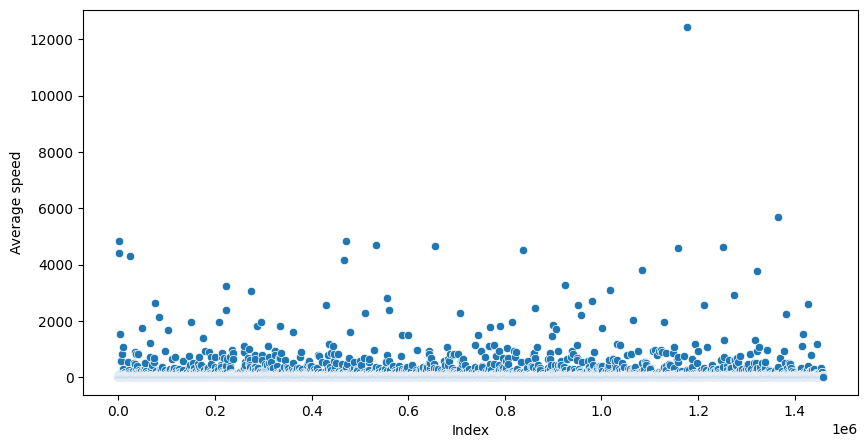

In [ ]:
avg_speed = taxi_data['total_distance'] / taxi_data['trip_duration'] * 3.6
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(x=avg_speed.index, y=avg_speed, ax=ax)
ax.set_xlabel('Index')
ax.set_ylabel('Average speed');

Как раз отсюда мы видим, что у нас есть “поездки-телепортации”, для которых средняя скорость более 1000 км/ч. Даже есть такая, средняя скорость которой составляла более 12000 км/ч!

Давайте условимся, что предельная средняя скорость, которую могут развивать таксисты будет 300 км/ч.


### Задание 2.11.
Найдите поездки, длительность которых превышает 24 часа. И удалите их из набора данных.

а) Сколько выбросов по признаку длительности поездки вам удалось найти?

Найдите поездки, средняя скорость которых по кратчайшему пути превышает 300 км/ч и удалите их из данных.

б) Сколько выбросов по признаку скорости вам удалось найти?

In [ ]:
# Поиск поездок, длительность которых превышает 24 часа (86400 секунд)
print(f"Число выбросов по длительности поездки: {taxi_data[taxi_data['trip_duration'] > 86400].shape[0]}")

# Удаление выбросов по длительности поездки
taxi_data = taxi_data[taxi_data['trip_duration'] <= 86400]

# Поиск поездок, где средняя скорость по кратчайшему пути больше 300 км/ч
# Средняя скорость = (total_distance / trip_duration) * 3.6 (для перевода в км/ч)
print(f"Число выбросов по скорости: {taxi_data[taxi_data['total_distance'] / taxi_data['trip_duration'] * 3.6 > 300].shape[0]}")

# Удаление выбросов по скорости
taxi_data = taxi_data[taxi_data['total_distance'] / taxi_data['trip_duration'] * 3.6 <= 300]

# Печать обновленного размера данных
print(f"Размер данных после удаления выбросов: {taxi_data.shape}")


Число выбросов по длительности поездки: 4
Число выбросов по скорости: 407
Размер данных после удаления выбросов: (1458233, 26)


## 3. Разведывательный анализ данных (EDA)

В этой части нашего проекта мы с вами:
* Исследуем сформированный набор данных;
* Попробуем найти закономерности, позволяющие сформулировать предварительные гипотезы относительно того, какие факторы являются решающими в определении длительности поездки;
* Дополним наш анализ визуализациями, иллюстрирующими; исследование. Постарайтесь оформлять диаграммы с душой, а не «для галочки»: навыки визуализации полученных выводов обязательно пригодятся вам в будущем.


Начинаем с целевого признака. Забегая вперед, скажем, что основной метрикой качества решения поставленной задачи будет RMSLE - Root Mean Squared Log Error, которая вычисляется на основе целевой переменной в логарифмическом масштабе. В таком случае целесообразно сразу логарифмировать признак длительности поездки и рассматривать при анализе логарифм в качестве целевого признака:
$$trip\_duration\_log = log(trip\_duration+1),$$
где под символом log подразумевается натуральный логарифм.


In [ ]:
taxi_data['trip_duration_log'] = np.log(taxi_data['trip_duration']+1)

<ipython-input-42-6bc05e83115d>:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  histplot = sns.histplot(
<ipython-input-42-6bc05e83115d>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  boxplot = sns.boxplot(


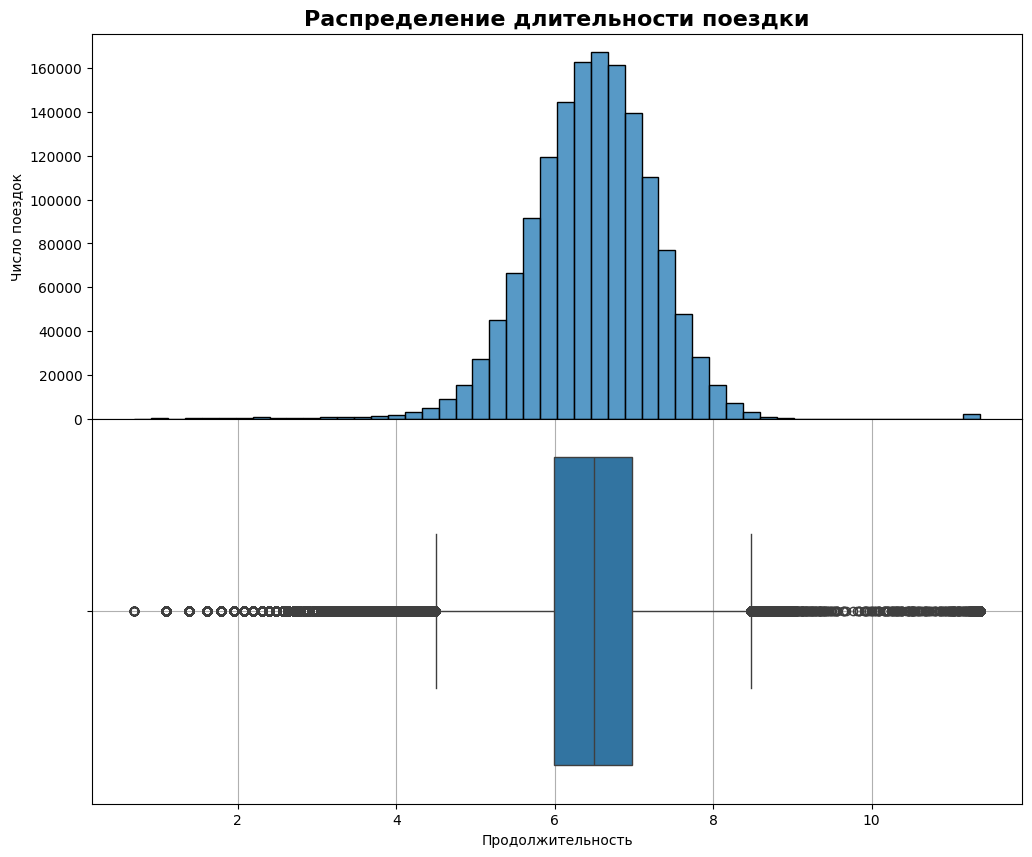

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))
plt.subplots_adjust(hspace=.0)

histplot = sns.histplot(
    data=taxi_data[['trip_duration_log']],
    x='trip_duration_log',
    bins=50,
    ax=axes[0],
    palette='tab10',
)
histplot.set_title('Распределение длительности поездки', fontweight='semibold', fontsize=16)
histplot.set_ylabel('Число поездок')
boxplot = sns.boxplot(
    data=taxi_data[['trip_duration_log']],
    x='trip_duration_log',
    orient='h',
    palette='tab10',
)
boxplot.set_xlabel('Продолжительность')
boxplot.set_ylabel(' ')
boxplot.grid()

### Задание 3.1.
Постройте гистограмму и коробчатую диаграмму длительности поездок в логарифмическом масштабе (trip_duration_log).
Исходя из визуализации, сделайте предположение, является ли полученное распределение нормальным?
Проверьте свою гипотезу с помощью теста Д’Агостино при уровне значимости $\alpha=0.05$.

а) Чему равен вычисленный p-value? Ответ округлите до сотых.

б) Является ли распределение длительности поездок в логарифмическом масштабе нормальным?

In [ ]:
np.array(taxi_data['trip_duration_log'])

array([6.12249281, 6.49828215, 7.66152708, ..., 6.63987583, 5.9242558 ,
       5.29330482])

In [ ]:
from scipy.stats import normaltest
# нулевая и альтернативная гипотезы
H0 = 'Распределение отлично от нормального'
H1 = 'Распределения нормальное'
k2, p =  normaltest(np.array(taxi_data['trip_duration_log']))
alpha = 0.05
print(f"p_value = {round(p, 30)}")
if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("Отвергаем нулевую гипотезу. {}".format(H0))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))


p_value = 0.0
Отвергаем нулевую гипотезу. Распределение отлично от нормального


In [ ]:
from scipy.stats import shapiro
# нулевая и альтернативная гипотезы
H0 = 'Распределение отлично от нормального'
H1 = 'Распределения нормальное'
alpha = 0.05 # уровень значимости
# вычисляем результат теста Шапиро-Уилка для выборок
shapiro_result = shapiro(np.array(taxi_data['trip_duration_log'])[:5000])
print('p-value =', round(shapiro_result.pvalue, 3))
# сравниваем полученное p-value с уровнем значимости
if shapiro_result.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value = 0.0
Отвергаем нулевую гипотезу. Распределение отлично от нормального


### Задание 3.2.
Постройте визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от таксопарка (vendor_id).

Сравните два распределения между собой.

<ipython-input-46-4d22fb0d952e>:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  histplot = sns.histplot(
<ipython-input-46-4d22fb0d952e>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  boxplot = sns.boxplot(
<ipython-input-46-4d22fb0d952e>:26: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  histplot = sns.histplot(
<ipython-input-46-4d22fb0d952e>:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  boxplot = sns.boxplot(


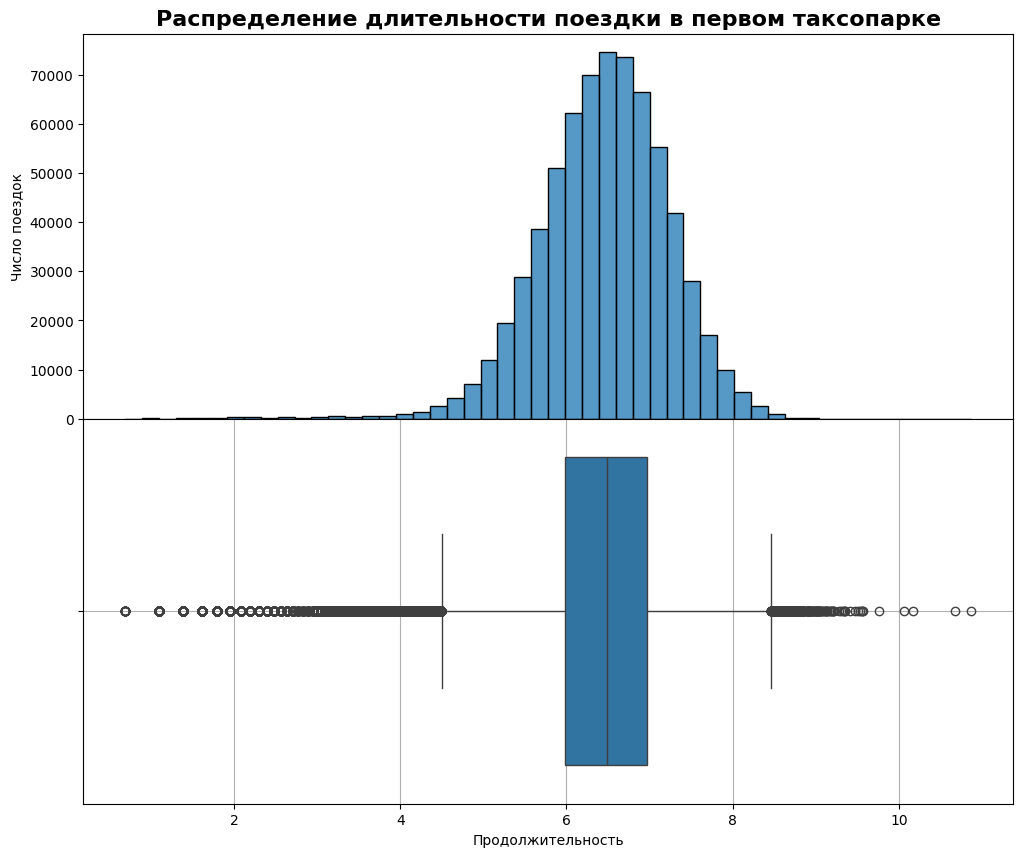

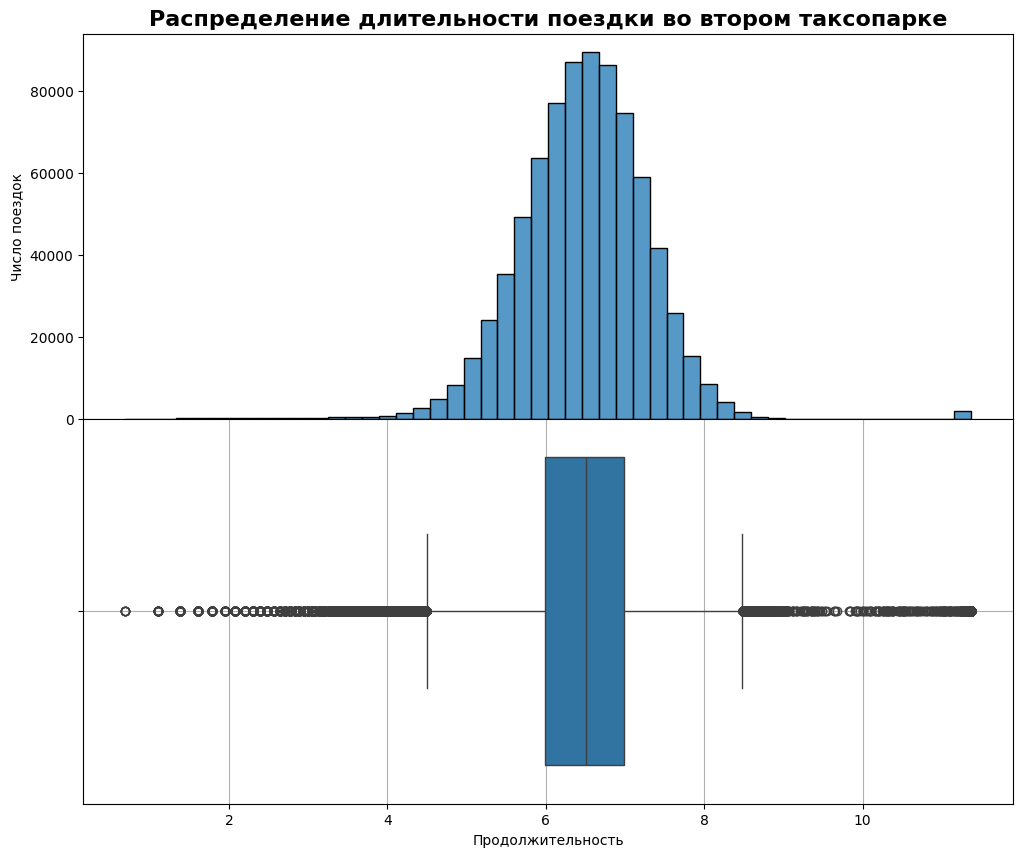

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))
plt.subplots_adjust(hspace=.0)

histplot = sns.histplot(
    data=taxi_data[taxi_data['vendor_id'] == 1][['trip_duration_log']],
    x='trip_duration_log',
    bins=50,
    ax=axes[0],
    palette='tab10',
)
histplot.set_title('Распределение длительности поездки в первом таксопарке', fontweight='semibold', fontsize=16)
histplot.set_ylabel('Число поездок')
boxplot = sns.boxplot(
    data=taxi_data[taxi_data['vendor_id'] == 1][['trip_duration_log']],
    x='trip_duration_log',
    orient='h',
    palette='tab10',
)
boxplot.set_xlabel('Продолжительность')
boxplot.set_ylabel(' ')
boxplot.grid()

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))
plt.subplots_adjust(hspace=.0)

histplot = sns.histplot(
    data=taxi_data[taxi_data['vendor_id'] == 2][['trip_duration_log']],
    x='trip_duration_log',
    bins=50,
    ax=axes[0],
    palette='tab10',
)
histplot.set_title('Распределение длительности поездки во втором таксопарке', fontweight='semibold', fontsize=16)
histplot.set_ylabel('Число поездок')
boxplot = sns.boxplot(
    data=taxi_data[taxi_data['vendor_id'] == 2][['trip_duration_log']],
    x='trip_duration_log',
    orient='h',
    palette='tab10',
)
boxplot.set_xlabel('Продолжительность')
boxplot.set_ylabel(' ')
boxplot.grid()

### Задание 3.3.
Постройте визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от признака отправки сообщения поставщику (store_and_fwd_flag).

Сравните два распределения между собой.

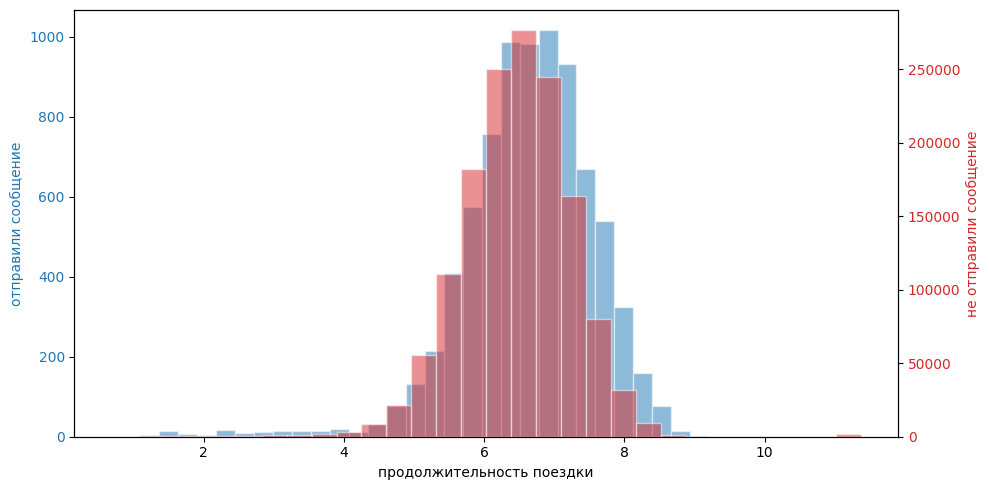

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 5))

color = 'tab:blue'
ax1.set_xlabel('продолжительность поездки')
ax1.set_ylabel('отправили сообщение', color=color)
ax1.hist(taxi_data[taxi_data['store_and_fwd_flag'] == 'Y'][['trip_duration_log']],
         bins=30,
         edgecolor="white",
         alpha=0.5,
         color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('не отправили сообщение', color=color)  # we already handled the x-label with ax1
ax2.hist(taxi_data[taxi_data['store_and_fwd_flag'] == 'N'][['trip_duration_log']],
         bins=30,
         edgecolor="white",
         alpha=0.5,
         color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

<ipython-input-48-c5612bff4c93>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  boxplot = sns.boxplot(


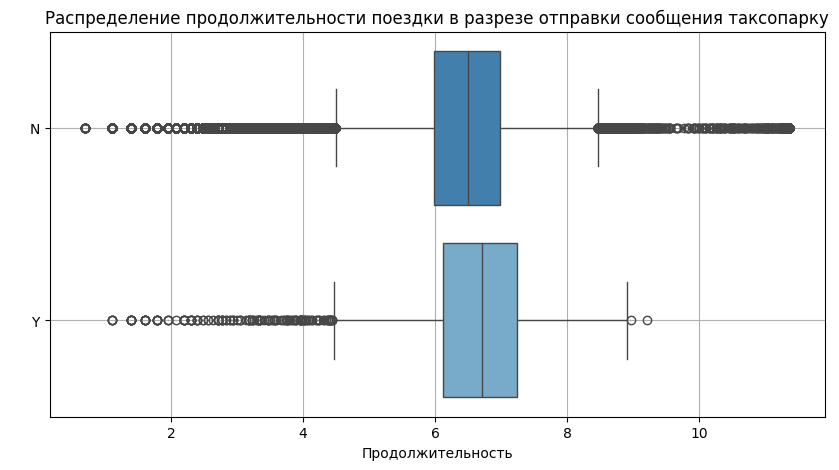

In [ ]:
df = taxi_data[['store_and_fwd_flag','trip_duration_log']]
fig = plt.figure(figsize=(10, 5))
boxplot = sns.boxplot(
    data=df,
    y='store_and_fwd_flag',
    x='trip_duration_log',
    orient='h',
    palette='tab20c',

)
boxplot.set_title('Распределение продолжительности поездки в разрезе отправки сообщения таксопарку')
boxplot.set_xlabel('Продолжительность')
boxplot.set_ylabel(' ')
boxplot.grid()

In [ ]:
df_1 = pd.DataFrame(taxi_data[taxi_data['store_and_fwd_flag'] == 'Y'][['trip_duration_log']].describe())
df_2 = pd.DataFrame(taxi_data[taxi_data['store_and_fwd_flag'] == 'N'][['trip_duration_log']].describe())
joined = df_1.join(df_2, lsuffix='_Y', rsuffix='_N', how='left')
joined['diff'] = joined['trip_duration_log_Y'] - joined['trip_duration_log_N']
joined.round(3)

,trip_duration_log_Y,trip_duration_log_N,diff
count,8041.000,1450192.000,-1442151.000
mean,6.633,6.467,0.166
std,0.941,0.791,0.149
min,1.099,0.693,0.405
25%,6.125,5.986,0.138
50%,6.702,6.497,0.205
75%,7.246,6.980,0.266
max,9.209,11.367,-2.158


### Задание 3.4.
Постройте две визуализации:
* Распределение количества поездок в зависимости от часа дня;
* Зависимость медианной длительности поездки от часа дня.

На основе построенных графиков ответьте на следующие вопросы:

а) В какое время суток такси заказывают реже всего?

б) В какое время суток наблюдается пик медианной длительности поездок?

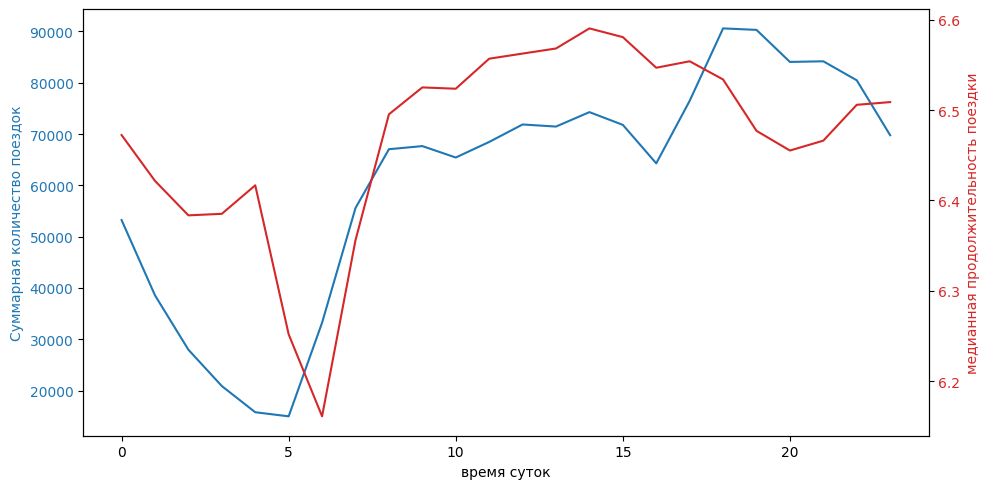

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.set_xlabel('время суток')
ax1.set_ylabel('Суммарная количество поездок', color='tab:blue')
ax1.plot(taxi_data.groupby(by='pickup_hour')['trip_duration_log'].count(),
         color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.set_ylabel('медианная продолжительность поездки', color='tab:red')  # we already handled the x-label with ax1
ax2.plot(taxi_data.groupby(by='pickup_hour')['trip_duration_log'].median(),
         color='tab:red')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

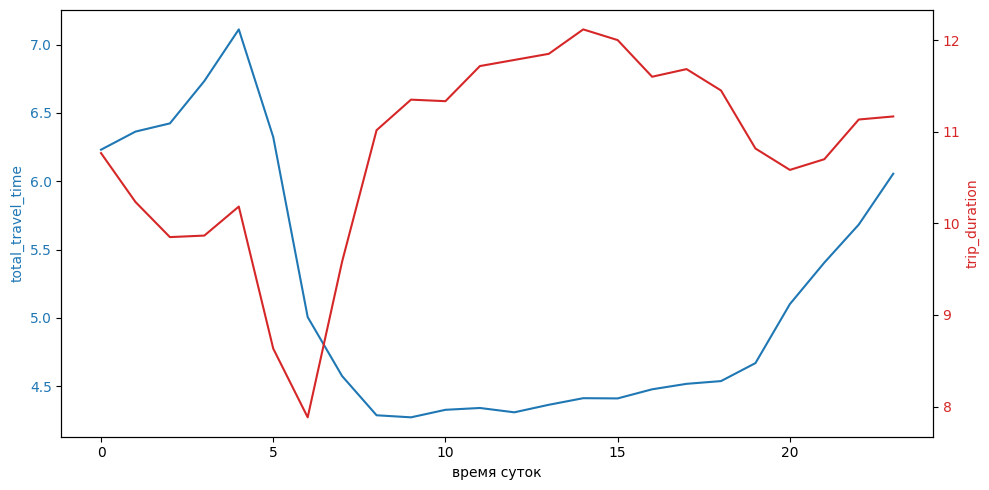

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.set_xlabel('время суток')
ax1.set_ylabel('total_travel_time', color='tab:blue')
ax1.plot(taxi_data.groupby("pickup_hour")['total_travel_time'].median() / 60, color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.set_ylabel('trip_duration', color='tab:red')  # we already handled the x-label with ax1
ax2.plot(taxi_data.groupby("pickup_hour")['trip_duration'].median() / 60, color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

### Задание 3.5.
Постройте две визуализации:
* Распределение количества поездок в зависимости от дня недели;
*  Зависимость медианной длительности поездки от дня недели.

На основе построенных графиков ответьте на следующие вопросы:
а) В какой день недели совершается больше всего поездок?
б) В какой день недели медианная длительность поездок наименьшая?


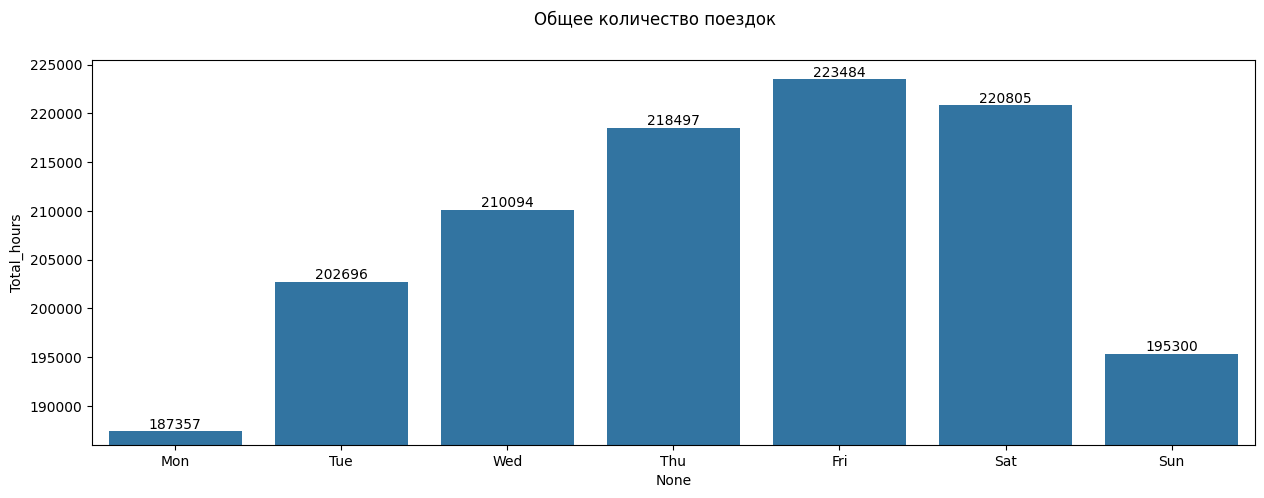

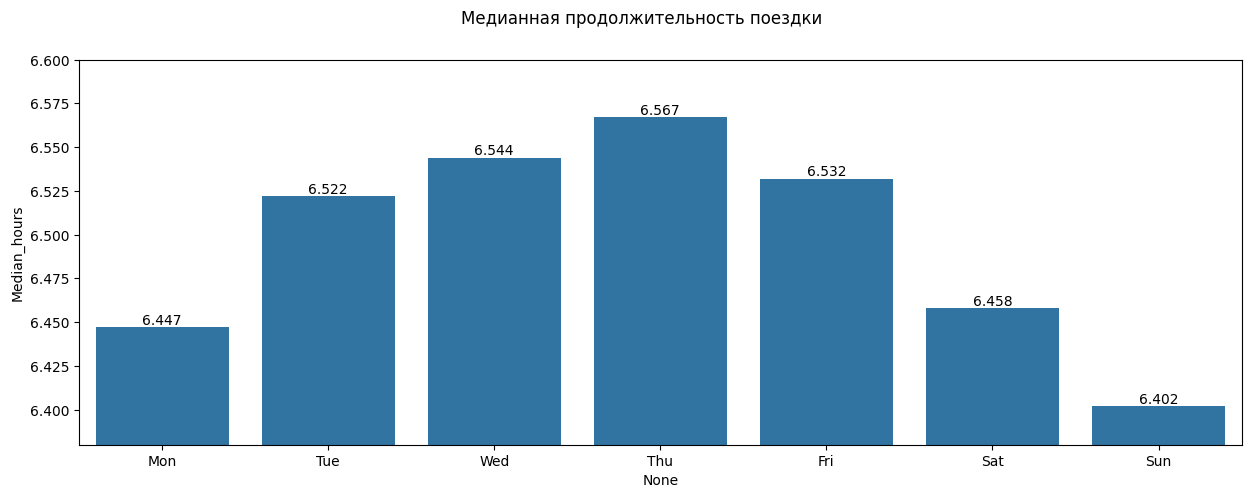

In [ ]:
df = pd.DataFrame({'Total_hours':taxi_data.groupby(by='pickup_day_of_week')['trip_duration_log'].count().values,
                   'Median_hours':taxi_data.groupby(by='pickup_day_of_week')['trip_duration_log'].median().values},
                  index = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']).round(3)

fig, ax = plt.subplots(figsize=(15, 5))
plt.suptitle('Общее количество поездок')
plt.ylim(186000, 225500)
sns.barplot(x=df.index, y=df['Total_hours'])
ax.bar_label(ax.containers[0]);
fig, ax = plt.subplots(figsize=(15, 5))
plt.suptitle('Медианная продолжительность поездки')
plt.ylim(6.38, 6.6)
sns.barplot(x=df.index, y=df['Median_hours'])
ax.bar_label(ax.containers[0]);

### Задание 3.6.
Посмотрим на обе временные характеристики одновременно.

Постройте сводную таблицу, по строкам которой отложены часы (pickup_hour), по столбцам - дни недели (pickup_day_of_week), а в ячейках - медианная длительность поездки (trip_duration).

Визуализируйте полученную сводную таблицу с помощью тепловой карты (рекомендуемая палитра - coolwarm).

In [ ]:
taxi_data['trip_duration_log'].median()

6.498282149476434

Text(0.5, 1.0, 'Медианная продолжительность поездки')

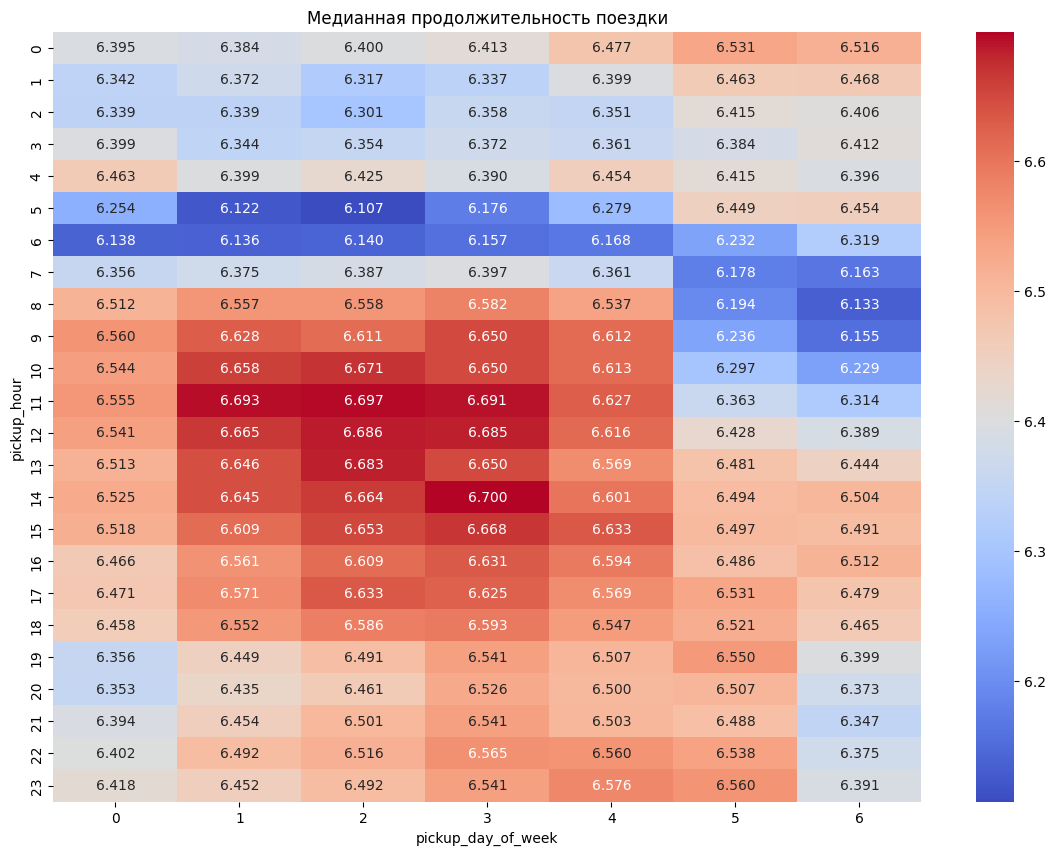

In [ ]:
pivot = taxi_data.pivot_table(
    values='trip_duration_log',
    index='pickup_hour',
    columns='pickup_day_of_week',
    aggfunc='median'
)

fig = plt.figure(figsize=(14, 10))

heat = sns.heatmap(pivot, cmap='coolwarm', annot=True, fmt=".3f")
heat.set_title('Медианная продолжительность поездки')

### Задание 3.7.
Постройте две диаграммы рассеяния (scatter-диаграммы):
* первая должна иллюстрировать географическое расположение точек начала поездок (pickup_longitude, pickup_latitude)
* вторая должна географическое расположение точек завершения поездок (dropoff_longitude, dropoff_latitude).

Для этого на диаграммах по оси абсцисс отложите широту (longitude), а по оси ординат - долготу (latitude).
Включите в визуализацию только те точки, которые находятся в пределах Нью-Йорка - добавьте следующие ограничения на границы осей абсцисс и ординат:

city_long_border = (-74.03, -73.75)

city_lat_border = (40.63, 40.85)

Добавьте на диаграммы расцветку по десяти географическим кластерам (geo_cluster), которые мы сгенерировали ранее.

**Рекомендация:** для наглядности уменьшите размер точек на диаграмме рассеяния.  


In [ ]:
fig = plt.figure(figsize=(14, 10))

city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

filtered_data = taxi_data[(taxi_data['pickup_longitude'] >= city_long_border[0]) &
                          (taxi_data['pickup_longitude'] <= city_long_border[1]) &
                          (taxi_data['pickup_latitude'] >= city_lat_border[0]) &
                          (taxi_data['pickup_latitude'] <= city_lat_border[1])]

scatter_start =  px.scatter(
    filtered_data,
    x='pickup_longitude',
    y='pickup_latitude',
    color='geo_cluster',
    labels={'pickup_longitude': 'Долгота', 'pickup_latitude': 'Широта'},
    title='Географическое расположение точек начала поездок',
    opacity=0.8,
    size='geo_cluster'

)

scatter_start.update_traces(marker=dict(size=5))
scatter_start.show()

(40.63, 40.85)

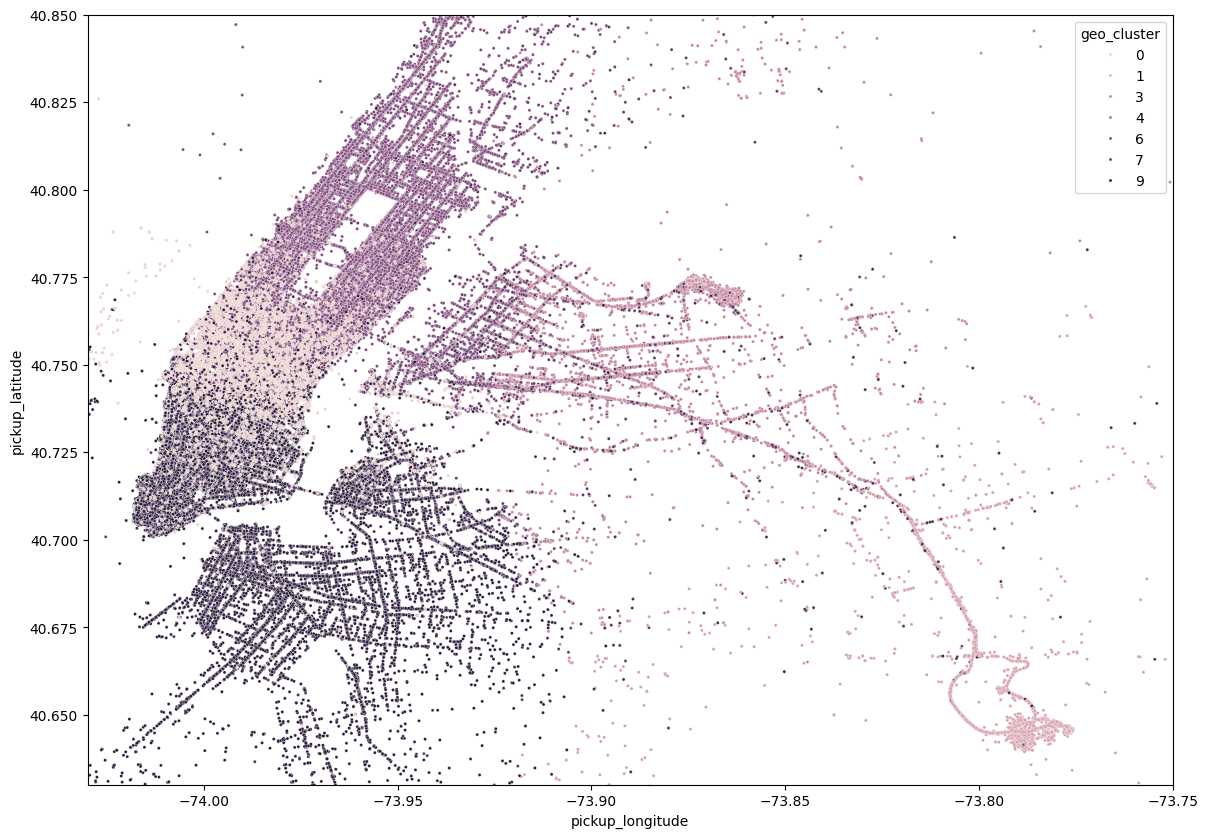

In [ ]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

fig = plt.figure(figsize=(14, 10))
scatter = sns.scatterplot(data=taxi_data, x='pickup_longitude', y='pickup_latitude', hue='geo_cluster', s=5)
scatter.set_xlim(city_long_border)
scatter.set_ylim(city_lat_border)

## 4. Отбор и преобразование признаков

Перед тем как перейти к построению модели, осталось сделать ещё несколько шагов.
* Следует помнить, что многие алгоритмы машинного обучения не могут обрабатывать категориальные признаки в их обычном виде. Поэтому нам необходимо их закодировать;
* Надо отобрать признаки, которые мы будем использовать для обучения модели;
*  Необходимо масштабировать и трансформировать некоторые признаки для того, чтобы улучшить сходимость моделей, в основе которых лежат численные методы.


In [ ]:
print('Shape of data: {}'.format(taxi_data.shape))
print('Columns: {}'.format(taxi_data.columns))

Shape of data: (1458233, 27)
Columns: Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_date', 'pickup_hour', 'pickup_day_of_week',
       'pickup_holiday', 'total_distance', 'total_travel_time',
       'number_of_steps', 'haversine_distance', 'direction', 'geo_cluster',
       'temperature', 'visibility', 'wind speed', 'precip', 'events',
       'trip_duration_log'],
      dtype='object')


Для удобства работы сделаем копию исходной таблицы с поездками:

In [ ]:
train_data = taxi_data.copy()
train_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,number_of_steps,haversine_distance,direction,geo_cluster,temperature,visibility,wind speed,precip,events,trip_duration_log
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,5.0,1.498521,99.970196,6,4.4,8.0,27.8,0.3,None,6.122493
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,6.0,1.805507,-117.153768,9,28.9,16.1,7.4,0.0,None,6.498282
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,16.0,6.385098,-159.680165,9,-6.7,16.1,24.1,0.0,None,7.661527
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,4.0,1.485498,-172.737700,9,7.2,16.1,25.9,0.0,None,6.063785
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,5.0,1.188588,179.473585,6,9.4,16.1,9.3,0.0,None,6.077642


### Задание 4.1.
Сразу позаботимся об очевидных неинформативных и избыточных признаках.

а) Какой из признаков является уникальным для каждой поездки и не несет полезной информации в определении ее продолжительности?

б) Утечка данных (data leak) - это…

в) Подумайте, наличие какого из признаков в обучающем наборе данных создает утечку данных?

г) Исключите выбранные в пунктах а) и в) признаки из исходной таблицы с данными. Сколько столбцов в таблице у вас осталось?


In [ ]:
train_data = train_data.drop(['id', 'dropoff_datetime'], axis=1)
print('Shape of data:  {}'.format(train_data.shape))

Shape of data:  (1458233, 25)


Ранее мы извлекли всю необходимую для нас информацию из даты начала поездки, теперь мы можем избавиться от этих признаков, так как они нам больше не понадобятся:


In [ ]:
drop_columns = ['pickup_datetime', 'pickup_date']
train_data = train_data.drop(drop_columns, axis=1)
print('Shape of data:  {}'.format(train_data.shape))

Shape of data:  (1458233, 23)


### Задание 4.2.

Закодируйте признак vendor_id в таблице train_data таким образом, чтобы он был равен 0, если идентификатор таксопарка равен 1, и 1 — в противном случае.

Закодируйте признак store_and_fwd_flag в таблице train_data таким образом, чтобы он был равен 0, если флаг выставлен в значение 'N', и 1 — в противном случае.

а) Рассчитайте среднее по закодированному столбцу vendor_id. Ответ приведите с точностью до сотых.

б) Рассчитайте среднее по закодированному столбцу store_and_fwd_flag. Ответ приведите с точностью до тысячных.



In [ ]:
train_data['vendor_id'] = train_data['vendor_id'].apply(lambda x: 0 if x == 1 else 1)
train_data['store_and_fwd_flag'] = train_data['store_and_fwd_flag'].apply(lambda x: 0 if x == 'N' else 1)

print(f"vendor_id_mean = {round(train_data['vendor_id'].mean(), 2)}")
print(f"store_and_fwd_flag = {round(train_data['store_and_fwd_flag'].mean(), 3)}")

vendor_id_mean = 0.53
store_and_fwd_flag = 0.006


### Задание 4.3.
Создайте таблицу data_onehot из закодированных однократным кодированием признаков pickup_day_of_week, geo_cluster и events в таблице train_data с помощью OneHotEncoder из библиотеки sklearn. Параметр drop выставите в значение 'first', чтобы удалять первый бинарный столбец, тем самым не создавая излишних признаков.

В параметре handle_unknown установите значение 'ignore'. Это позволит коду отработать без ошибок в случае появления в тестовой выборке значений, отсутствующих в обучающей выборке.

В результате работы OneHotEncoder вы получите безымянный numpy-массив, который нам будет необходимо преобразовать обратно в DataFrame, для более удобной работы в дальнейшем. Чтобы получить имена закодированных столбцов у объекта типа OneHotEncoder есть специальный метод get_feature_names_out(). Он возвращает список новых закодированных имен столбцов в формате <оригинальное имя столбца>_<имя категории>.

Пример использования:

``` python
# Объявляем кодировщик
one_hot_encoder = OneHotEncoder(drop='first', handle_unknown='ignore')
# Получаем закодированные имена столбцов
column_names = one_hot_encoder.get_feature_names_out()
# Составляем DataFrame из закодированных признаков
data_onehot = pd.DataFrame(data_onehot, columns=column_names)
```

В этом псевдокоде:
* one_hot_encoder - объект класса OneHotEncoder
* data_onehot - numpy-массив, полученный в результате трансформации кодировщиком

В результате выполнения задания у вас должен быть образован DataFrame `data_onehot`, который содержит кодированные категориальные признаки pickup_day_of_week, geo_cluster и events.


Сколько бинарных столбцов у вас получилось сгенерировать с помощью однократного кодирования?


In [ ]:
df_1 = train_data.copy()

In [ ]:
from sklearn.preprocessing import OneHotEncoder
scaler = preprocessing.MinMaxScaler()
one_hot_encoder = OneHotEncoder(drop='first')

columns_to_change = ['pickup_day_of_week', 'geo_cluster', 'events']

data_onehot = one_hot_encoder.fit_transform(train_data[columns_to_change]).toarray()

column_names = one_hot_encoder.get_feature_names_out(columns_to_change)

best_features = column_names

data_onehot = one_hot_encoder.transform(train_data[columns_to_change]).toarray()

data_onehot = pd.DataFrame(data_onehot, columns=column_names)

print(data_onehot.shape)

(1458233, 18)


Добавим полученную таблицу с закодированными признаками:

In [ ]:
train_data = pd.concat(
    [train_data.reset_index(drop=True).drop(columns_to_change, axis=1), data_onehot],
    axis=1
)
print('Shape of data: {}'.format(train_data.shape))

Shape of data: (1458233, 38)


Теперь, когда категориальные признаки предобработаны, сформируем матрицу наблюдений X, вектор целевой переменной y и его логарифм y_log. В матрицу наблюдений войдут все столбцы из таблицы с поездками за исключением целевого признака trip_duration и его логарифмированной версии trip_duration_log:


In [ ]:
X = train_data.drop(['trip_duration', 'trip_duration_log'], axis=1)
y = train_data['trip_duration']
y_log = train_data['trip_duration_log']

Все наши модели мы будем обучать на логарифмированной версии y_log.

Выбранный тип валидации - hold-out. Разобьем выборку на обучающую и валидационную в соотношении 67/33:

In [ ]:
X_train, X_valid, y_train_log, y_valid_log = model_selection.train_test_split(
    X, y_log,
    test_size=0.33,
    random_state=42
)

На данный момент у нас достаточно много признаков: скорее всего, не все из них будут важны. Давайте оставим лишь те, которые сильнее всего связаны с целевой переменной и точно будут вносить вклад в повышение качества модели.


### Задание 4.4.
С помощью SelectKBest отберите 25 признаков, наилучшим образом подходящих для предсказания целевой переменной в логарифмическом масштабе. Отбор реализуйте по обучающей выборке, используя параметр score_func = f_regression.

Укажите признаки, которые вошли в список отобранных


In [ ]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer
import numpy as np

# Преобразуем целевую переменную в логарифмический масштаб
X = taxi_data.drop(columns=['trip_duration'])  # Все признаки, кроме целевой переменной
y = taxi_data['trip_duration']

# Преобразуем целевую переменную в логарифмический масштаб
transformer = FunctionTransformer(np.log1p, validate=True)
y_log = transformer.fit_transform(y.values.reshape(-1, 1))

# Удалим нечисловые признаки (например, идентификаторы)
X = X.select_dtypes(include=[np.number])

# Разделяем данные на обучающую и тестовую выборки
X_train, X_val, y_train_log, y_val_log = train_test_split(X, y_log, test_size=0.2, random_state=42)

# Применяем SelectKBest с использованием f_regression для отбора 25 признаков
selector = SelectKBest(score_func=f_regression, k=25)
X_train_selected = selector.fit_transform(X_train, y_train_log)

# Получаем индексы и имена отобранных признаков
selected_features = X_train.columns[selector.get_support()]

# Применяем выбранные признаки к валидационной выборке
X_val_selected = X_val[selected_features]

# Выводим список отобранных признаков
print(f'Отобранные признаки: {list(selected_features)}')

# Теперь в X_train_selected и X_val_selected содержатся только отобранные 25 признаков



/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning:

k=25 is greater than n_features=20. All the features will be returned.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Отобранные признаки: ['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'pickup_hour', 'pickup_day_of_week', 'pickup_holiday', 'total_distance', 'total_travel_time', 'number_of_steps', 'haversine_distance', 'direction', 'geo_cluster', 'temperature', 'visibility', 'wind speed', 'precip', 'trip_duration_log']


Так как мы будем использовать различные модели, в том числе внутри которых заложены численные методы оптимизации, то давайте заранее позаботимся о масштабировании факторов.


### Задание 4.5.
Нормализуйте предикторы в обучающей и валидационной выборках с помощью MinMaxScaler из библиотеки sklearn. Помните, что обучение нормализатора производится на обучающей выборке, а трансформация на обучающей и валидационной!

Рассчитайте среднее арифметическое для первого предиктора (т. е. для первого столбца матрицы) из валидационной выборки. Ответ округлите до сотых.


In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Нормализуем обучающую выборку
scaler = MinMaxScaler()

# Нормализуем обучающие и валидационные данные
X_train_scaled = scaler.fit_transform(X_train_selected)
X_val_scaled = scaler.transform(X_val_selected)

# Рассчитываем среднее арифметическое для первого предиктора из валидационной выборки
mean_first_feature_val = np.mean(X_val_scaled[:, 0])

# Округляем до сотых
mean_first_feature_val_rounded = round(mean_first_feature_val, 2)

# Выводим результат
print(f"Среднее арифметическое первого предиктора в валидационной выборке: {mean_first_feature_val_rounded}")


Среднее арифметическое первого предиктора в валидационной выборке: 0.54


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but MinMaxScaler was fitted without feature names



## 5. Решение задачи регрессии: линейная регрессия и деревья решений

Определим метрику, по которой мы будем измерять качество наших моделей. Мы будем следовать канонам исходного соревнования на Kaggle и в качестве метрики использовать RMSLE (Root Mean Squared Log Error), которая вычисляется как:
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(log(y_i+1)-log(\hat{y_i}+1))^2},$$
где:
* $y_i$ - истинная длительность i-ой поездки на такси (trip_duration)
* $\hat{y_i}$- предсказанная моделью длительность i-ой поездки на такси

Заметим, что логарифмирование целевого признака мы уже провели заранее, поэтому нам будет достаточно вычислить метрику RMSE для модели, обученной прогнозировать длительность поездки такси в логарифмическом масштабе:
$$z_i=log(y_i+1),$$
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(z_i-\hat{z_i})^2}=\sqrt{MSE(z_i,\hat{z_i})}$$



### Задание 5.1.
Постройте модель линейной регрессии на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию.

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [ ]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train_log)

y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)

In [ ]:
def rmsle(y_real, y_pred):
    mse = np.sum(np.square(np.subtract(y_real, y_pred))) / len(y_real)
    return np.sqrt(mse)

In [ ]:
print(f"RMSLE on train: {round(rmsle(y_train_log, y_train_pred), 2)}")
print(f"RMSLE on valid: {round(rmsle(y_valid_log, y_valid_pred), 2)}")

RMSLE on train: 0.53
RMSLE on valid: 0.53


In [ ]:
lr_model = linear_model.LinearRegression()
lr_model.fit(X_train, y_train_log)

# Прогноз на тренировочной выборке
y_train_pred_log = lr_model.predict(X_train)

# Прогноз на валидационной выборке
y_valid_pred_log = lr_model.predict(X_valid)

# Обратное преобразование логарифмических прогнозов в исходную шкалу
y_train_pred = np.exp(y_train_pred_log)
y_valid_pred = np.exp(y_valid_pred_log)
#Выводим значения метрики

print(f'RMSLE train score: {round(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_pred_log)), 2)}')

print(f'RMSLE valid score: {round(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_pred_log)), 2)}')
# Вычисление метрики RMSLE на тренировочной и валидационной выборках
rmsle_train = np.sqrt(metrics.mean_squared_error(y_train_log, y_train_pred_log))
rmsle_valid = np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_pred_log))

RMSLE train score: 0.53
RMSLE valid score: 0.53


In [ ]:
import pandas as pd
import numpy as np
import sklearn

print(pd.__version__)
print(np.__version__)
print(sklearn.__version__)

2.0.1
1.26.4
1.2.2


### Задание 5.2.
Сгенерируйте полиномиальные признаки 2-ой степени с помощью PolynomialFeatures из библиотеки sklearn. Параметр include_bias выставите в значение False.

Постройте модель полиномиальной регрессии 2-ой степени на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию.

а) Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.

б) Наблюдаются ли у вашей модели признаки переобучения?


In [ ]:
# создаём скейлер-генератор полиномиальных признаков
# degree. Default to 2.
PF_scaler = preprocessing.PolynomialFeatures(include_bias=False);
PF_scaler.fit(X_train_scaled);

# генерируем полиномиальные признаки для тренировочной выборки
X_train_scaled_poly = PF_scaler.transform(X_train_scaled);

# генерируем полиномиальные признаки для тестовой выборки
X_valid_scaled_poly = PF_scaler.transform(X_valid_scaled);

# выводим результат
X_train_scaled_poly.shape
X_valid_scaled_poly.shape

PolynomialFeatures(include_bias=False)

(977016, 350)

(481217, 350)

In [ ]:
# ответ на вопрос а)
get_model_metrics(
    get_estimator('linear'),
    X_train_=X_train_scaled_poly, y_train_=y_train_log,
    X_test_=X_valid_scaled_poly, y_test_=y_valid_log
)


-= LinearRegression =-
RMSLE на обучающей выборке: 0.47249
RMSLE на валидационной выборке: 0.67797


### Задание 5.3.
Постройте модель полиномиальной регрессии 2-ой степени с L2-регуляризацией (регуляризация по Тихонову) на обучающей выборке  (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Коэффициент регуляризации $\alpha$ установите равным 1, остальные параметры оставьте по умолчанию.

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [ ]:
# ответ на вопрос
get_model_metrics(
    get_estimator('ridge'),
    X_train_=X_train_scaled_poly, y_train_=y_train_log,
    X_test_=X_valid_scaled_poly, y_test_=y_valid_log
)

-= Ridge =-
RMSLE на обучающей выборке: 0.47937
RMSLE на валидационной выборке: 0.48270


In [ ]:
del PF_scaler, X_train_scaled_poly, X_valid_scaled_poly
gc.collect();

### Задание 5.4.
Постройте модель дерева решений (DecisionTreeRegressor) на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию.

а) Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.

б) Наблюдаются ли у вашей модели признаки переобучения?


In [ ]:
# ответ на вопрос а)
get_model_metrics(
    get_estimator('dtr'),
    X_train_=X_train_scaled, y_train_=y_train_log,
    X_test_=X_valid_scaled, y_test_=y_valid_log
)

-= DecisionTreeRegressor =-
RMSLE на обучающей выборке: 0.00305
RMSLE на валидационной выборке: 0.56737


### Задание 5.5.
Переберите все возможные варианты глубины дерева решений в диапазоне от 7 до 20:

max_depths = range(7, 20)

Параметр random_state задайте равным 42.

Постройте линейные графики изменения метрики RMSE на тренировочной и валидационной выборках в зависимости от значения параметра глубины дерева решений.

а) Найдите оптимальное значение максимальной глубины дерева, для которой будет наблюдаться минимальное значение RMSLE на обучающей выборке, но при этом еще не будет наблюдаться переобучение (валидационная кривая еще не начинает возрастать).

б) Чему равно значение метрик RMSLE на тренировочной и валидационной выборках для дерева решений с выбранной оптимальной глубиной? Ответ округлите до сотых.


In [ ]:
# ответ на вопрос а)
get_model_metrics(
    get_estimator('dtr'),
    X_train_=X_train_scaled, y_train_=y_train_log,
    X_test_=X_valid_scaled, y_test_=y_valid_log
)

-= DecisionTreeRegressor =-
RMSLE на обучающей выборке: 0.00305
RMSLE на валидационной выборке: 0.56737


In [ ]:
# задаём границы глубины деревьев
start, stop = 7, 20
metrics_ord_dict = OrderedDict()

# цикл для всех шагов глубины дерева
for step in range(start, stop + 1):
    # словарь параметров модели
    params_dtr = {
        'max_depth': step
    }

    # результаты метрик заносим в OrderedDict
    # ключ равен текущей глубине дерева (шагу итерации)
    DTR, _, metrics_ord_dict[step] = get_model_metrics(
        get_estimator('dtr', **params_dtr),
        X_train_=X_train_scaled, y_train_=y_train_log,
        X_test_=X_valid_scaled, y_test_=y_valid_log,
        print_metrics=False,
        return_values=True
    )

    # выводим результат
    print(f'Max_depth: {step:2d}, '\
        f'RMSLE train: {metrics_ord_dict[step][0]:.{TOL}f}, '\
        f'RMSLE valid: {metrics_ord_dict[step][1]:.{TOL}f}')

Max_depth:  7, RMSLE train: 0.44482, RMSLE valid: 0.44716
Max_depth:  8, RMSLE train: 0.43704, RMSLE valid: 0.44084
Max_depth:  9, RMSLE train: 0.43006, RMSLE valid: 0.43571
Max_depth: 10, RMSLE train: 0.42261, RMSLE valid: 0.43116
Max_depth: 11, RMSLE train: 0.41475, RMSLE valid: 0.43018
Max_depth: 12, RMSLE train: 0.40603, RMSLE valid: 0.42926
Max_depth: 13, RMSLE train: 0.39585, RMSLE valid: 0.43215
Max_depth: 14, RMSLE train: 0.38406, RMSLE valid: 0.43891
Max_depth: 15, RMSLE train: 0.37087, RMSLE valid: 0.44676
Max_depth: 16, RMSLE train: 0.35594, RMSLE valid: 0.45280
Max_depth: 17, RMSLE train: 0.34005, RMSLE valid: 0.46361
Max_depth: 18, RMSLE train: 0.32294, RMSLE valid: 0.47382
Max_depth: 19, RMSLE train: 0.30480, RMSLE valid: 0.48517
Max_depth: 20, RMSLE train: 0.28569, RMSLE valid: 0.49468


In [ ]:
# ответ на вопрос а) и б)
# ищем в OrderedDict кортеж (пару) с наименьшим значением в паре среди всех кортежей
min_pair = min(metrics_ord_dict.values(), key=lambda x: x[1])

# ищем ключ кортежа в OrderedDict от пары с наименьшим значением
key = list(metrics_ord_dict.keys())[list(metrics_ord_dict.values()).index(min_pair)]

# индекс ключа от кортежа (пары) с наименьшим значением
best_max_depth = list(metrics_ord_dict.keys()).index(key)

# задаём списки для переноса значений
train_scores, valid_scores = [], []

# забираем по ключу соответствующие значения из кортежей в 1 и 2 списки
for step in metrics_ord_dict.values():
    train_scores.append(step[0])
    valid_scores.append(step[1])

# выводим результат
print(f'Лучшая глубина дерева: {key}')
print(f'RMSLE train с max_depth {key}: {train_scores[best_max_depth]:.{TOL}f}')
print(f'RMSLE valid с max_depth {key}: {valid_scores[best_max_depth]:.{TOL}f}')

# ответ в модуле: 12 !!!

Лучшая глубина дерева: 12
RMSLE train с max_depth 12: 0.40603
RMSLE valid с max_depth 12: 0.42926


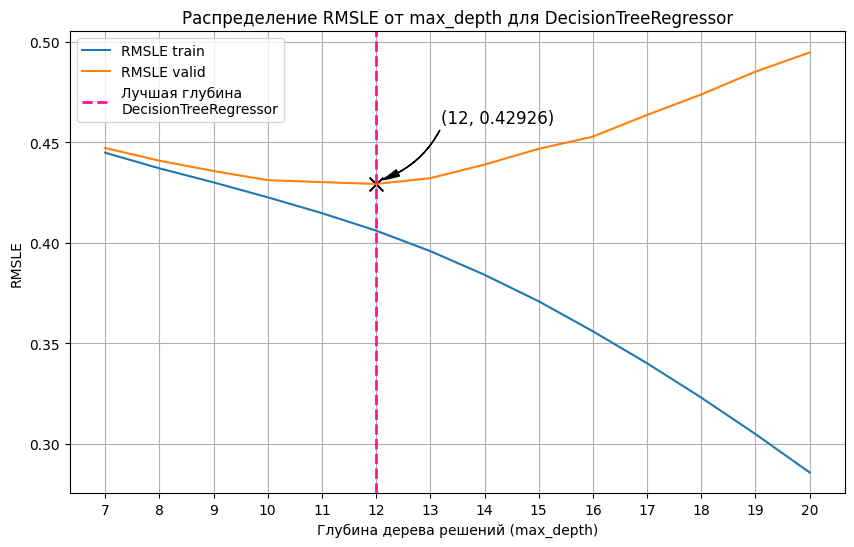

In [ ]:
# задаём полотно
fig, ax = plt.subplots(figsize=(10, 6))

# выделяем координаты
x_, y_ = key, round(valid_scores[best_max_depth], TOL)

# строим графики
sns.lineplot(x=range(start, stop + 1), y=train_scores, label='RMSLE train', ax=ax)
sns.lineplot(x=range(start, stop + 1), y=valid_scores, label='RMSLE valid', ax=ax)
plt.axvline(x=x_, label=f'Лучшая глубина\n{DTR.__class__.__name__}', lw=2, c='deeppink', ls='--')

# аннотируем детали графика
plt.scatter(x=x_, y=y_, c='black', marker='x', s=100)
plt.annotate(
    f'({x_}, {y_})',
    xy=(x_*1.01, y_*1.005),
    xytext=(x_*1.1, y_*1.07),
    arrowprops = dict(
        facecolor='black',
        width=0.2,
        headwidth=5,
        connectionstyle="arc3, rad=-0.2"
    ),
    fontsize=12,
    horizontalalignment='left')

# задаём заголовок, подписи и лимиты оси абсцисс
ax.set(
    title=f'Распределение RMSLE от max_depth для {DTR.__class__.__name__}',
    xlabel='Глубина дерева решений (max_depth)',
    ylabel='RMSLE',
    xticks=range(start, stop + 1)
)

# выводим сетку и легенду
ax.grid()
ax.legend();

In [ ]:
# прибираемся немного
del start, stop, step, DTR, metrics_ord_dict, params_dtr
del min_pair, best_max_depth, train_scores, valid_scores
del x_, y_, fig, ax
gc.collect();

## 6. Решение задачи регрессии: ансамблевые методы и построение прогноза

Переходим к тяжелой артиллерии: ансамблевым алгоритмам.

### Задание 6.1.

Постройте модель случайного леса на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). В качестве гиперпараметров укажите следующие:
* n_estimators=200,
* max_depth=12,
* criterion='squared_error',
* min_samples_split=20,
* random_state=42

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [ ]:
params_rfr = {
    'n_estimators':200,
    'max_depth':key,
    'criterion':'squared_error',
    'min_samples_split':20,
    'verbose':True
}

get_model_metrics(
    get_estimator('rfr', **params_rfr),
    X_train_=X_train_scaled, y_train_=y_train_log,
    X_test_=X_valid_scaled, y_test_=y_valid_log
)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   57.5s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  5.7min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    2.9s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    3.3s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    1.3s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    1.5s finished


-= RandomForestRegressor =-
RMSLE на обучающей выборке: 0.39932
RMSLE на валидационной выборке: 0.41410


In [ ]:
# прибираемся немного
del params_rfr, key
gc.collect();

### Задание 6.2.
Постройте модель градиентного бустинга над деревьями решений (GradientBoostingRegressor) на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). В качестве гиперпараметров укажите следующие:
* learning_rate=0.5,
* n_estimators=100,
* max_depth=6,
* min_samples_split=30,
* random_state=42

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [ ]:
params_gbr = {
    'learning_rate':0.5,
    'n_estimators':100,
    'max_depth':6,
    'min_samples_split':30,
    'verbose':True
}

# возвращаем модель и предсказанные значения на валидационной выборке
GBR, y_pred_valid_gbr_log, *_ = get_model_metrics(
    get_estimator('gbr', **params_gbr),
    X_train_=X_train_scaled, y_train_=y_train_log,
    X_test_=X_valid_scaled, y_test_=y_valid_log,
    return_values=True
)

      Iter       Train Loss   Remaining Time 
         1           0.3110           11.02m
         2           0.2247           10.79m
         3           0.1987           10.75m
         4           0.1876           10.63m
         5           0.1825           10.50m
         6           0.1780           10.40m
         7           0.1752           10.24m
         8           0.1729           10.15m
         9           0.1712            9.98m
        10           0.1700            9.88m
        20           0.1596            8.69m
        30           0.1545            7.45m
        40           0.1508            6.34m
        50           0.1479            5.26m
        60           0.1457            4.19m
        70           0.1438            3.14m
        80           0.1420            2.08m
        90           0.1405            1.04m
       100           0.1391            0.00s
-= GradientBoostingRegressor =-
RMSLE на обучающей выборке: 0.37295
RMSLE на валидационной выборке:

In [ ]:
# прибираемся немного
del params_gbr
gc.collect();

### Задание 6.3.
Какая из построенных вами моделей показала наилучший результат (наименьшее значение RMSLE на валидационной выборке)?

* <font color=Tomato>**&cross;**</font> Линейная регрессия
* <font color=Tomato>**&cross;**</font> Полиномиальная регрессия 2-ой степени
* <font color=Tomato>**&cross;**</font> Дерево решений
* <font color=Tomato>**&cross;**</font> Случайный лес
* <font color=LightSeaGreen>**&check;**</font> **Градиентный бустинг над деревьями решений**
* <font color=LightSeaGreen>**&check;**</font> **XGBoost**

<br>

| Обученная модель | RMSLE<br> на валидационной выборке |
| :---: | :---: |
| LinearRegression | 0.53 |
| Ridge | 0.48 |
| DecisionTreeRegressor | 0.43 |
| RandomForestRegressor | 0.41 |
| **GradientBoostingRegressor** | <font color=LightSeaGreen>**0.393**</font> |
| **XGBoost** | <font color=LightSeaGreen>**0.391**</font> |

<br>

### Задание 6.4.
Постройте столбчатую диаграмму коэффициентов значимости каждого из факторов.

Укажите топ-3 наиболее значимых для предсказания целевого признака - длительности поездки в логарифмическом масштабе - факторов.


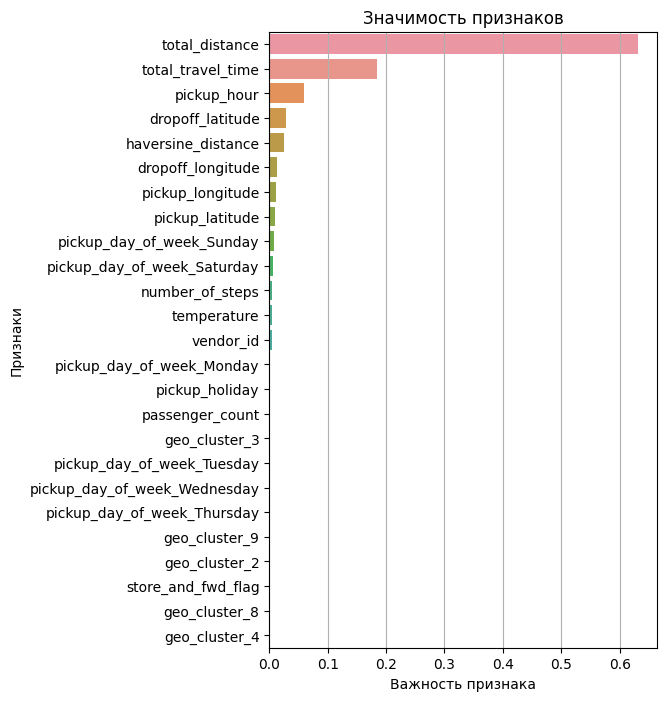

In [ ]:
# задаём полотно
fig, ax = plt.subplots(figsize=(5, 8))

# формируем датасет для построения столбчатого графика
feat_importances = pd.Series(
    GBR.feature_importances_,
    index=SKBst_selector_cols).sort_values(
        ascending=False
)

# задаём сетку
ax.grid()

# строим график
sns.barplot(
    x=feat_importances,
    y=feat_importances.index,
    orient='h'
)

# задаём заголовок, подписи осей
ax.set(
    title='Значимость признаков',
    xlabel='Важность признака',
    ylabel='Признаки'
);

In [ ]:
print(f'Топ-3 наиболее значимых признака для предсказания:\n{feat_importances[:3]}')


Топ-3 наиболее значимых признака для предсказания:
total_distance       0.632001
total_travel_time    0.185002
pickup_hour          0.058864
dtype: float64


In [ ]:
# прибираемся немного
del fig, ax, feat_importances
gc.collect();

### Задание 6.5.
Для лучшей из построенных моделей рассчитайте медианную абсолютную ошибку (MeAE - в sklearn функция median_absolute_error) предсказания длительности поездки такси на валидационной выборке:
$$ MeAE = median(|y_i-\hat{y_i}|)$$

Значение метрики MeAE переведите в минуты и округлите до десятых.


In [ ]:
# переводим вектора целевого и предсказанных значений из логарифмического в обычный вид
y_valid = np.exp(y_valid_log) - 1
y_pred_valid_gbr = np.exp(y_pred_valid_gbr_log) - 1

# вычисляем метрику MeAE
round(metrics.median_absolute_error(y_valid, y_pred_valid_gbr) / 60, 1)

1.8

In [ ]:
# прибираемся немного
del y_valid, y_pred_valid_gbr, y_pred_valid_gbr_log
gc.collect();

Финальный шаг - сделать submit -  предсказание для отложенного тестового набора данных.

Прочитаем тестовые данные и заранее выделим столбец с идентификаторами поездок из тестового набора данных. Он нам еще пригодится:


In [ ]:
# задаём переменные для выгрузки датасета
test_data_file = DATA_SUBFOLDER + './data/Project5_test_data.csv'
test_data_url = 'https://drive.google.com/file/d/1C2N2mfONpCVrH95xHJjMcueXvvh_-XYN/view'

# загружаем датасет
test_data = get_dataset(test_data_file, test_data_url, 'g', ',', DATA_SUBFOLDER + './data/test.csv')

# задаём переменные для выгрузки датасета
osrm_data_test_file = DATA_SUBFOLDER + './data/Project5_osrm_data_test.csv'
osrm_data_test_url = 'https://drive.google.com/file/d/1wCoS-yOaKFhd1h7gZ84KL9UwpSvtDoIA/view'

# загружаем датасет
osrm_data_test = get_dataset(osrm_data_test_file, osrm_data_test_url, 'g', ',', DATA_SUBFOLDER + './data/osrm_data_test.csv')

test_id = test_data['id']

In [ ]:
# прибираемся немного
del test_data_file, test_data_url
del osrm_data_test_file, osrm_data_test_url
gc.collect();

Перед созданием прогноза для тестовой выборки необходимо произвести все манипуляции с данными, которые мы производили с тренировочной выборкой, а именно:
* Перевести признак pickup_datetime в формат datetime;
* Добавить новые признаки (временные, географические, погодные и другие факторы);
* Произвести очистку данных от пропусков;
* Произвести кодировку категориальных признаков:
    * Закодировать бинарные признаки;
    * Закодировать номинальные признаки с помощью обученного на тренировочной выборке OneHotEncoder’а;
* Сформировать матрицу наблюдений, оставив в таблице только те признаки, которые были отобраны с помощью SelectKBest;
* Нормализовать данные с помощью обученного на тренировочной выборке MinMaxScaler’а.


In [ ]:
# применяем преобразования с помощью функции
test_data = modify_data_types(test_data)
test_data = add_datetime_features(test_data)
test_data = add_holiday_features(test_data, holiday_data)
test_data = add_osrm_features(test_data, osrm_data_test)
test_data = add_geographical_features(test_data)
test_data = add_cluster_features(test_data, KMns)
test_data = add_weather_features(test_data, weather_data)
test_data = fill_null_weather_data(test_data)

# понижаем размерность признаков по типу занимаемых данных
test_data['number_of_steps'] = test_data['number_of_steps'].astype('int8')

# кодируем признаки
test_data['vendor_id'] = test_data['vendor_id'].swifter.apply(lambda x: 0 if x == 1 else 1)

# выполняем OneHot-кодирование
test_data_onehot = OHE_encoder.fit_transform(test_data[columns_to_change]).toarray()
column_names = OHE_encoder.get_feature_names_out(columns_to_change)
test_data_onehot = pd.DataFrame(test_data_onehot, columns=column_names)

# понижаем размерность признаков по типу занимаемых данных
test_data_onehot = test_data_onehot.astype('int8')

# составляем датафрейм из OneHot-закодированных признаков
test_data = pd.concat(
    [test_data.reset_index(drop=True).drop(columns_to_change, axis=1), test_data_onehot],
    axis=1
)

# выбираем k-признаки из данных
X_test = test_data[SKBst_selector_cols]

# транформируем данные обученным скейлером
X_test_scaled = MMS_scaler.transform(X_test)

# выводим результат
print(f'Shape of data: {X_test.shape}')

Pandas Apply:   0%|          | 0/625134 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/24 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/24 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/625134 [00:00<?, ?it/s]

Shape of data: (625134, 25)


In [ ]:
# выводим результат
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625134 entries, 0 to 625133
Data columns (total 38 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   id                            625134 non-null  object        
 1   vendor_id                     625134 non-null  int64         
 2   pickup_datetime               625134 non-null  datetime64[ns]
 3   passenger_count               625134 non-null  int8          
 4   pickup_longitude              625134 non-null  float32       
 5   pickup_latitude               625134 non-null  float32       
 6   dropoff_longitude             625134 non-null  float32       
 7   dropoff_latitude              625134 non-null  float32       
 8   store_and_fwd_flag            625134 non-null  int8          
 9   pickup_date                   625134 non-null  datetime64[ns]
 10  pickup_hour                   625134 non-null  int8          
 11  pickup_holida

In [ ]:
# прибираемся немного
del osrm_data_test, X_test, test_data_onehot, test_data
del KMns, OHE_encoder, MMS_scaler
del weather_data, holiday_data
del column_names, columns_to_change
gc.collect();

Только после выполнения всех этих шагов можно сделать предсказание длительности поездки для тестовой выборки. Не забудьте перевести предсказания из логарифмического масштаба в истинный, используя формулу:
$$y_i=exp(z_i)-1$$

После того, как вы сформируете предсказание длительности поездок на тестовой выборке вам необходимо будет создать submission-файл в формате csv, отправить его на платформу Kaggle и посмотреть на результирующее значение метрики RMSLE на тестовой выборке.

Код для создания submission-файла:


In [ ]:
y_test_pred_gbr_log = GBR.predict(X_test_scaled)
y_test_pred = np.exp(y_test_pred_gbr_log) - 1

submission = pd.DataFrame({'id': test_id, 'trip_duration': y_test_pred})
submission.to_csv(DATA_SUBFOLDER + './data/submission_gbr.csv', index=False)

In [ ]:
# прибираемся немного
del y_test_pred_gbr_log, y_test_pred, test_id, submission
# del GBR
gc.collect();

### **В качестве бонуса**

В завершение по ансамблевым мы предлагаем вам попробовать улучшить свое предсказание, воспользовавшись моделью экстремального градиентного бустинга (XGBoost) из библиотеки xgboost.

**XGBoost** - современная модель машинного обучения, которая является продолжением идеи градиентного бустинга Фридмана. У нее есть несколько преимуществ по сравнению с классической моделью градиентного бустинга из библиотеки sklearn: повышенная производительность путем параллелизации процесса обучения, повышенное качество решения за счет усовершенствования алгоритма бустинга, меньшая склонность к переобучению и широкий функционал возможности управления параметрами модели.


Для ее использования необходимо для начала установить пакет xgboost:

In [ ]:
#!pip install xgboost

После чего модуль можно импортировать:

In [ ]:
import xgboost as xgb

Перед обучением модели необходимо перевести наборы данных в тип данных xgboost.DMatrix:

In [ ]:
# создаём матрицы наблюдений в формате DMatrix
dtrain = xgb.DMatrix(X_train_scaled, label=y_train_log, feature_names=SKBst_selector_cols)
dvalid = xgb.DMatrix(X_valid_scaled, label=y_valid_log, feature_names=SKBst_selector_cols)
dtest = xgb.DMatrix(X_test_scaled, feature_names=SKBst_selector_cols)

Обучение модели XGBoost происходит с помощью метода train, в который необходимо передать параметры модели, набор данных, количество базовых моделей в ансамбле, а также дополнительные параметры:


In [ ]:
# гиперпараметры модели
params_xgb = {
    'min_child_weight': 20,
    'eta': 0.1,
    'colsample_bytree': 0.9,
    'max_depth': 6,
    'subsample': 0.9,
    'lambda': 1,
    'nthread': -1,
    'booster': 'gbtree',
    'eval_metric': 'rmse',
    'objective': 'reg:squarederror'
}

# тренировочная и валидационная выборка
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# обучаем модель XGBoost
XGB = xgb.train(
    params=params_xgb,          # гиперпараметры модели
    dtrain=dtrain,              # обучающая выборка
    num_boost_round=300,        # количество моделей в ансамбле
    evals=watchlist,            # выборки, на которых считается матрица
    early_stopping_rounds=20,   # раняя остановка
    maximize=False,             # смена поиска максимума на минимум
    verbose_eval=25             # шаг, через который происходит отображение метрик
)

[0]	train-rmse:5.42218	valid-rmse:5.42190
[25]	train-rmse:0.57514	valid-rmse:0.57667
[50]	train-rmse:0.40890	valid-rmse:0.41209
[75]	train-rmse:0.40030	valid-rmse:0.40443
[100]	train-rmse:0.39551	valid-rmse:0.40046
[125]	train-rmse:0.39269	valid-rmse:0.39823
[150]	train-rmse:0.39015	valid-rmse:0.39655
[175]	train-rmse:0.38800	valid-rmse:0.39510
[200]	train-rmse:0.38624	valid-rmse:0.39412
[225]	train-rmse:0.38471	valid-rmse:0.39361
[250]	train-rmse:0.38323	valid-rmse:0.39279
[275]	train-rmse:0.38148	valid-rmse:0.39177
[299]	train-rmse:0.38052	valid-rmse:0.39141


Предсказать целевой признак на новых данных можно с помощью метода predict():

In [ ]:
# выполняем предсказание на тестовом наборе данных
y_test_pred_xgb = np.exp(XGB.predict(dtest)) - 1
print(f'XGB test RMSLE {XGB.best_score:.{TOL}f}')

XGB test RMSLE 0.39141


Также как и все модели, основанные на использовании деревьев решений в качестве базовых моделей, XGBoost имеет возможность определения коэффициентов важности факторов. Более того, в библиотеку встроена возможность визуализации важность факторов в виде столбчатой диаграммы. За эту возможность отвечает функция plot_importance():


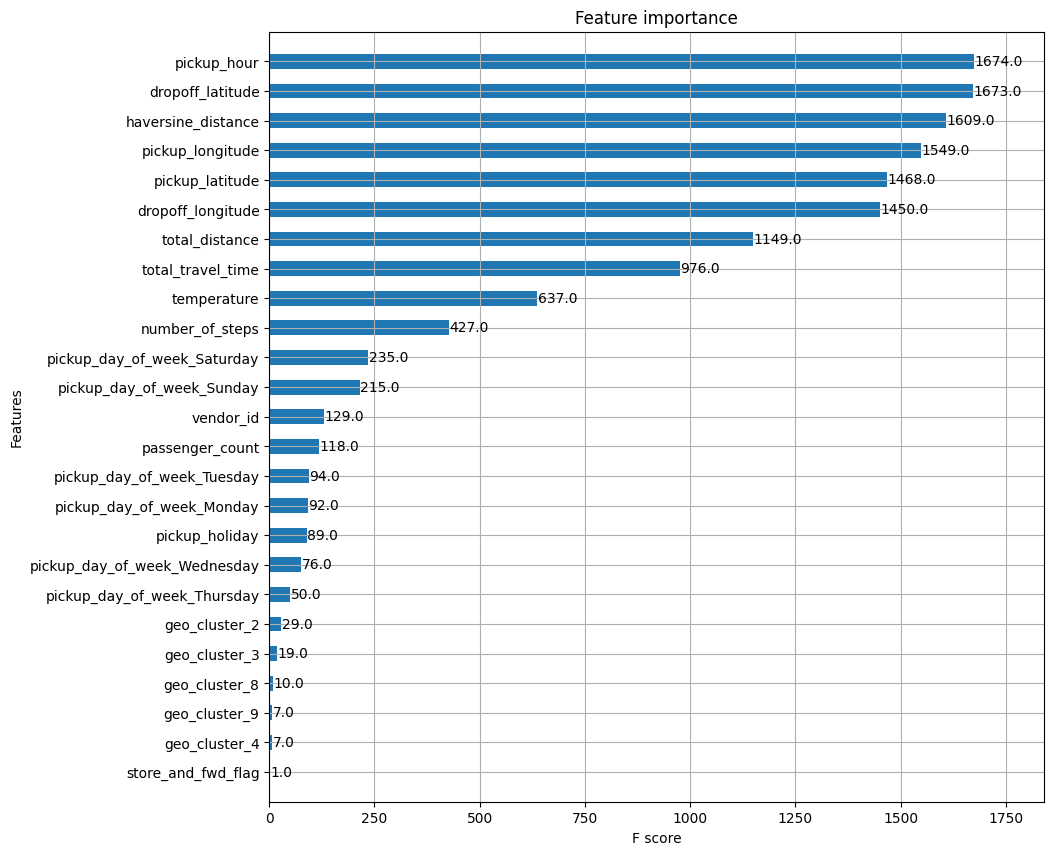

In [ ]:
fig, ax_xgb = plt.subplots(figsize = (10, 10))
xgb.plot_importance(booster=XGB, ax=ax_xgb, height=0.5);

In [ ]:
# прибираемся немного
del SKBst_selector_cols
del params_xgb, watchlist
del X_train_scaled, X_valid_scaled, X_test_scaled, y_train_log, y_valid_log
del dtrain, dvalid, dtest
del y_test_pred_xgb
del fig, ax_xgb
gc.collect();